In [1]:
%config Completer.use_jedi = False

In [1]:
%load_ext autoreload
%autoreload 2
import sklearn
import matplotlib
import matplotlib.font_manager as font_manager
import ncempy.io as nio
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import math
from sklearn.model_selection import train_test_split
from Analysis_objects_and_functions import *
from sklearn.metrics import r2_score
import glob
from mp_api.client import MPRester
from sklearn import tree
import pydotplus
import pickle
from platform import python_version

In [2]:
print('python version ' + python_version())
print('pandas version ' + pd.__version__)
print('numpy version ' + np.__version__)
print('sklearn version ' + sklearn.__version__)
print('matplotlib version ' + matplotlib.__version__)
print('joblib version ' + joblib.__version__)

python version 3.10.12
pandas version 1.5.3
numpy version 1.24.3
sklearn version 1.0.2
matplotlib version 3.7.1
joblib version 1.1.0


In [3]:
import mp_api
from mp_api.client import MPRester

<font size="6"> Load Data and Define XAS/EELS Analysis Object

In [4]:
test_rf_obj = eels_rf_setup('Dataset_generation/Cu_reproducable_alignment_df_extracted_110222.joblib') 
# initialize analysis object and add dataset path to it 
test_rf_obj.load_spectra_df() # load dataframe 
test_rf_obj.spectra_df['BV Used For Alignment'] = test_rf_obj.spectra_df['NEW BV Used For Alignment'] 
test_rf_obj.spectra_df['mpid_string'] = test_rf_obj.spectra_df['mp_id'] 

test_rf_obj.augment_df_with_mixtures() # run augmentation function that adds mixture spectra to the dataframe 

test_rf_obj.spectra_df['is_stable'] = np.zeros(len(test_rf_obj.spectra_df)) # this is no longer being stored as a part of the 
# model training and analysis
test_rf_obj.spectra_df['is_theoretical'] = np.zeros(len(test_rf_obj.spectra_df)) 

# if this is false, the material has been synthesized. This is how 
# the materials project defines this quantity

test_rf_obj.spectra_df.drop('level_0', axis = 1, inplace = True)
test_rf_obj.spectra_df.drop('index', axis = 1, inplace = True)

In [7]:
test_rf_obj.spectra_df.iloc[824]

mp_id                                                                                mp-704645
Energies                                     [932.7, 932.8, 932.9, 933.0, 933.1, 933.2, 933...
Spectrum                                     [0.14533635431166614, 0.1550097884826956, 0.16...
Structure                                    [[-1.0152155  1.1750365  2.5778995] Cu, [1.015...
pretty_formula                                                                             CuO
L3_Fermis                                                                            [934.985]
L2_Fermis                                                                            [954.953]
L3_avg_Fermi                                                                           934.985
L2_avg_Fermi                                                                           954.953
Absorbing_indicies                                                                         [0]
bv_sum                                            

In [5]:
# uncomment to visualize dataframe 
# print(test_rf_obj.spectra_df)

# percent of the test set that is an integer before mixture dataset is generated 
print(sum(np.asarray(test_rf_obj.spectra_df.iloc[0:3426]['BV Used For Alignment'].value_counts())[0:3])/3426)


0.9319906596614127


In [6]:
for t in np.asarray(test_rf_obj.spectra_df[['Mixture Components','mpid_string','BV Used For Alignment']]):
    if type(t[1]) != list:
        pass
    else:
        print(t[0], t[1], t[2])

[0.36651584 0.37556561 0.25791855] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 0.89
[0.19594595 0.33783784 0.46621622] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 1.27
[0.08943089 0.60162602 0.30894309] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 1.22
[0.46411483 0.16746411 0.36842105] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 0.9
[0.55828221 0.37423313 0.06748466] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 0.51
[0.46153846 0.24038462 0.29807692] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 0.84
[0.6137931  0.31034483 0.07586207] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 0.46
[0.14285714 0.18045113 0.67669173] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 1.53
[0.7080292  0.08029197 0.21167883] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 0.5
[0.19444444 0.51666667 0.28888889] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 1.09
[0.32038835 0.22815534 0.45145631] ['mp-864717', MPID(mp-1189310), 'mp-1198047'] 1.13
[0.32828283 0.21717172 0.45454545] ['mp-864717', MPID(mp

[0.14285714 0.14285714 0.71428571] ['mp-1147553', MPID(mp-8121), 'mp-510642'] 1.57
[0.16326531 0.23809524 0.59863946] ['mp-1147553', MPID(mp-8121), 'mp-510642'] 1.44
[0.46478873 0.36619718 0.16901408] ['mp-22696', MPID(mp-13348), 'mp-707201'] 0.7
[0.56842105 0.42105263 0.01052632] ['mp-22696', MPID(mp-13348), 'mp-707201'] 0.44
[0.42758621 0.23448276 0.33793103] ['mp-22696', MPID(mp-13348), 'mp-707201'] 0.91
[0.54545455 0.0979021  0.35664336] ['mp-22696', MPID(mp-13348), 'mp-707201'] 0.81
[0.20895522 0.45522388 0.3358209 ] ['mp-22696', MPID(mp-13348), 'mp-707201'] 1.13
[0.47236181 0.18592965 0.34170854] ['mp-22696', MPID(mp-13348), 'mp-707201'] 0.87
[0.3681592  0.16915423 0.46268657] ['mp-22696', MPID(mp-13348), 'mp-707201'] 1.09
[0.08974359 0.33974359 0.57051282] ['mp-22696', MPID(mp-13348), 'mp-707201'] 1.48
[0.41610738 0.22818792 0.3557047 ] ['mp-22696', MPID(mp-13348), 'mp-707201'] 0.94
[0.1572327  0.21383648 0.62893082] ['mp-22696', MPID(mp-13348), 'mp-707201'] 1.47
[0.29559748 0.1

[0.23404255 0.76595745 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.77
[0.62162162 0.37837838 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.38
[0.07142857 0.92857143 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.93
[0.91208791 0.08791209 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.09
[0.97142857 0.02857143 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.03
[0.36734694 0.63265306 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.63
[0.5 0.5 0. ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.5
[0.84761905 0.15238095 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.15
[0.66433566 0.33566434 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.34
[0.375 0.625 0.   ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.62
[0.4796748 0.5203252 0.       ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.52
[0.61616162 0.38383838 0.        ] ['mp-1080612', 'mp-1225724', MPID(mp-504573)] 0.38
[0.25 0.

[0.35576923 0.64423077 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.64
[0.36111111 0.63888889 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.64
[0.56129032 0.43870968 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.44
[0.45454545 0.54545455 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.55
[0.77777778 0.22222222 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.22
[0.07070707 0.92929293 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.93
[0.88043478 0.11956522 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.12
[0.71264368 0.28735632 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.29
[0.70454545 0.29545455 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.3
[0.32061069 0.67938931 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.68
[0.125 0.875 0.   ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0.87
[0.45299145 0.54700855 0.        ] ['mp-1225157', 'mp-1224445', MPID(mp-15613)] 0

<font size="6"> Train Random Foreset Model and Visualize Results - All 3 Components of Figure 2

In [8]:
# train random forest model with the cumulative spectrum, 500 trees, no max depth and all features available  
test_rf_obj.random_forest_train_bond_valance(bv_column='BV Used For Alignment',
                           spectra_to_predict = 'Cumulative_Spectra_TEAM_1_aligned_925_970',
                        energy_col = 'new Scaled Energies use', 
                                             max_features = 'auto')
# 0.9015603378827061

len training data = 7076
Using column: Cumulative_Spectra_TEAM_1_aligned_925_970 to predict: BV Used For Alignment
model accuracy (R^2) on simulated test data 0.9015603378827061


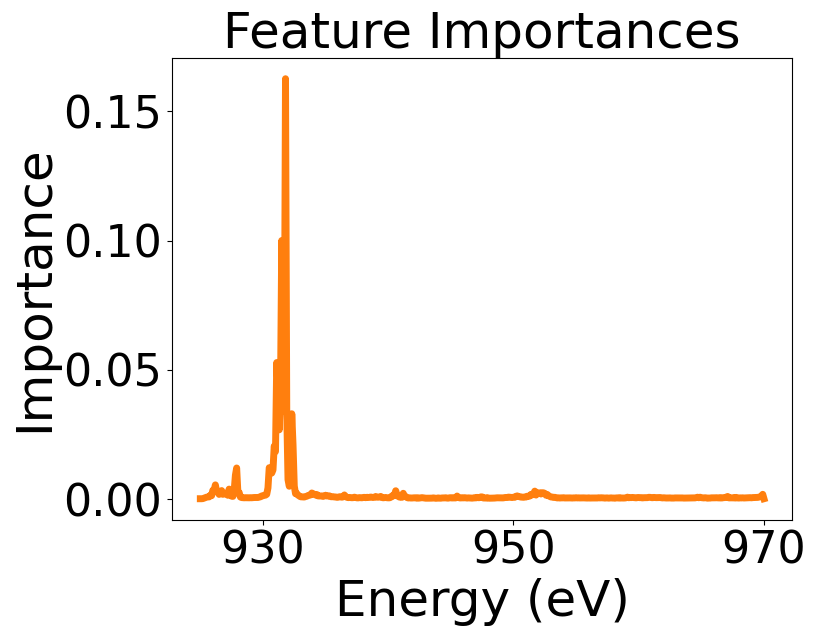

In [9]:
test_rf_obj.show_feature_importances('Cu', savefigure=False)
# visualize feature importances for the RF model 

num spectra = 2359
model accuracy (R^2) on simulated test data 0.9015603378827061
219
219
[164  99  96  76  64  59  56  50  50  39  37  34  34  34  32  32  31  30
  30  29  27  26  25  25  25  25  25  25  24  22  22  21  21  20  20  20
  18  18  17  17  17  17  17  16  16  16  15  15  15  14  14  13  13  13
  13  12  12  12  12  12  12  11  11  11  11  10  10  10   9   9   9   9
   9   8   8   8   8   8   8   8   7   7   7   7   7   7   6   6   6   6
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   4
   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   3   3   3
   3   3   3   3   3   3   3   3   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1]


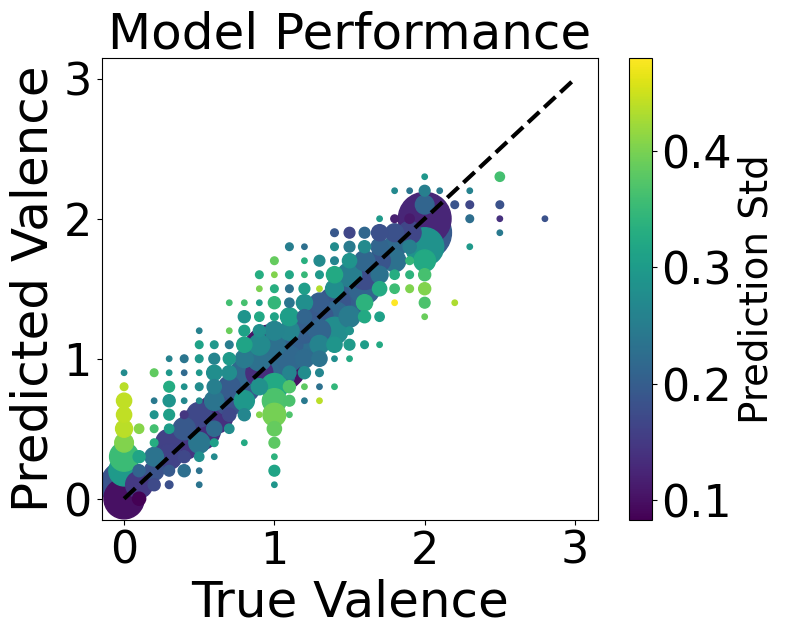

In [10]:
test_rf_obj.show_r2(savefigure=False)
# Show R2 plot for simulated data reserved from training. The top plot shows data colored by the number of points at 
# that position, while the bottom plot is colored by prediction standard deviation

num spectra = 2359
model accuracy (R^2) on simulated test data 0.9015603378827061
181
181
[64 50 39 37 34 34 34 32 31 30 30 27 26 25 25 25 25 25 25 22 22 21 21 20
 20 18 17 17 17 17 16 16 15 15 15 14 14 13 13 13 13 12 12 12 11 11 11 11
 10 10  9  9  9  9  9  8  8  8  8  8  7  7  7  7  7  6  6  6  6  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  3
  3  3  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1]


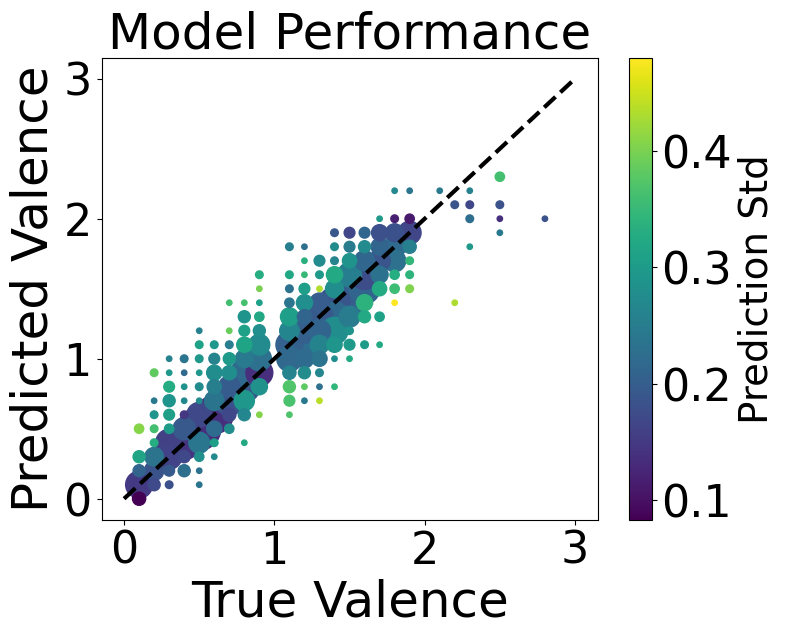

In [11]:
test_rf_obj.show_r2(savefigure=False, include_integer = False, scatter_spot_multiplier = 15)

RMSE 0.19641595506040008


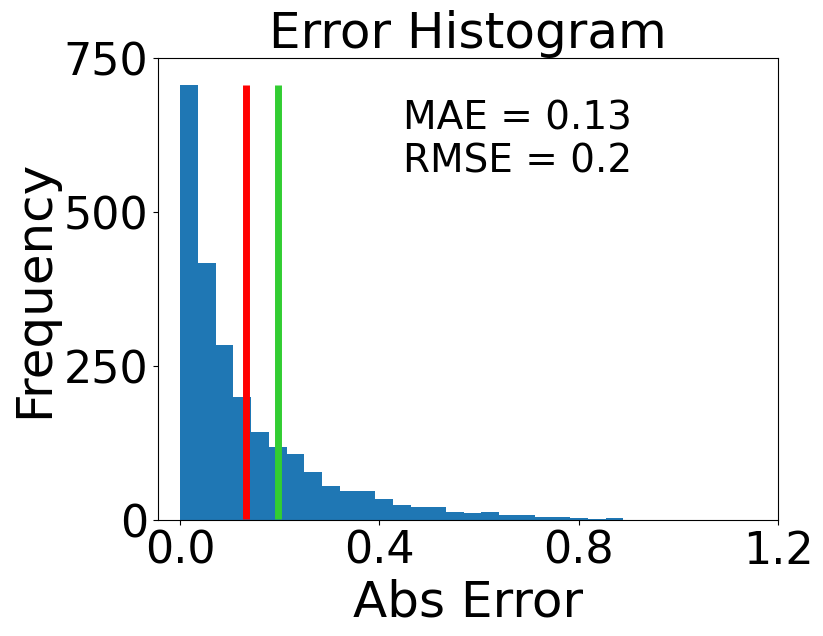

In [12]:
test_rf_obj.show_errors_histogram(nbins=25, savefigure=False)
# show error histogram for simulated data reserved from training. The solid green line is the location of the RMSE 
# 0.19641595506040005

<font size="6"> Visualize Dataset Distribution and The creation of Mixture Samples. Figure 1 II and III, and Figure S4

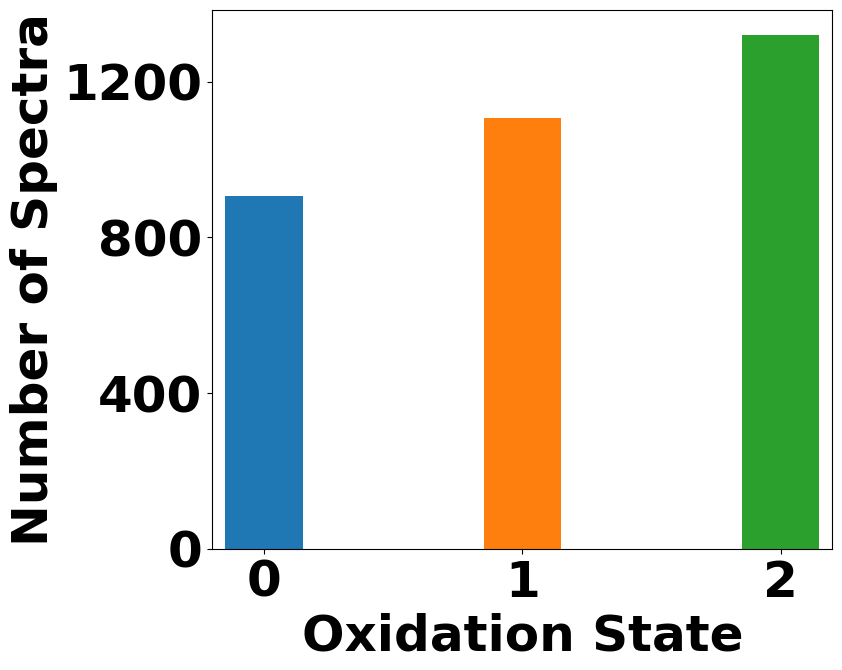

In [13]:
# show the number of integer valence spectra in the dataset before mixture generation 
test_rf_obj.visualize_mixture_addition(include_mixtures=False, savefigure=True)

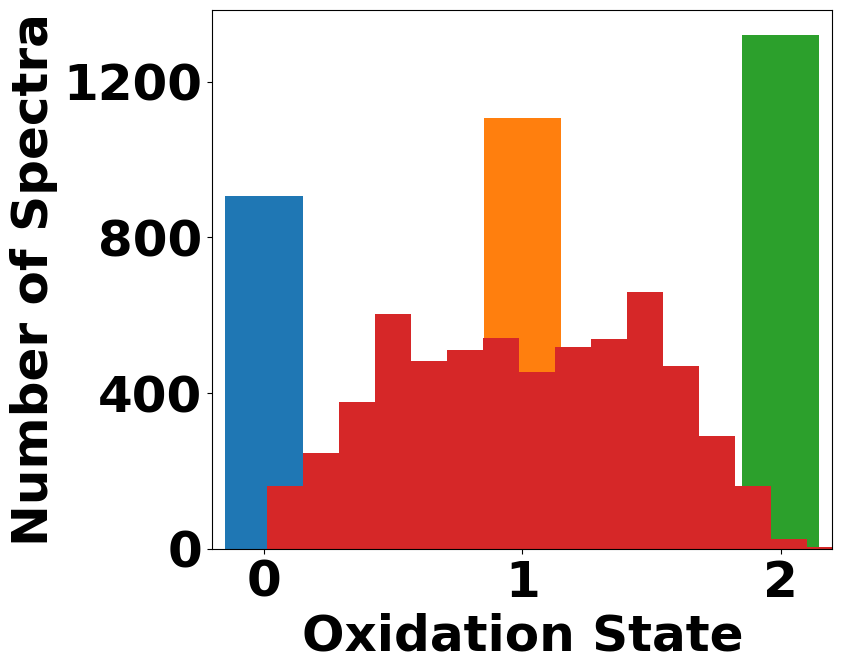

In [14]:
# show the spread of oxidation states post mixture dataset generation 
test_rf_obj.visualize_mixture_addition(include_mixtures=True, savefigure=True, right_y_ticks = False)

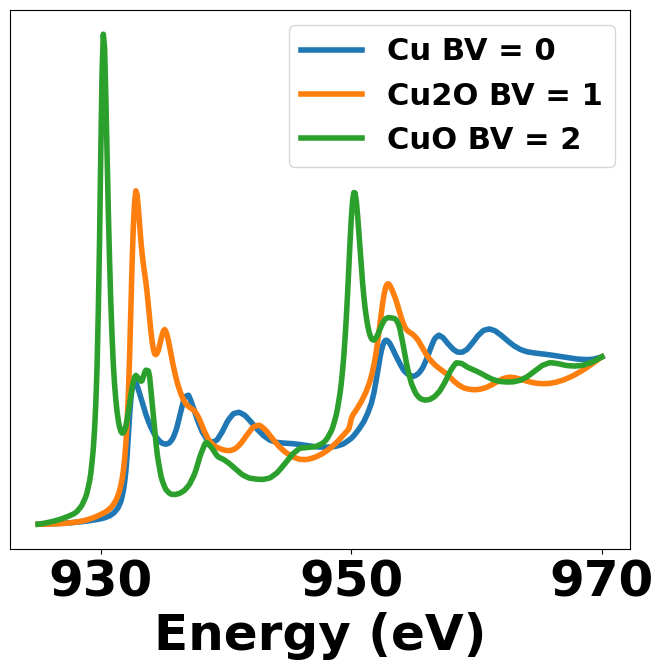

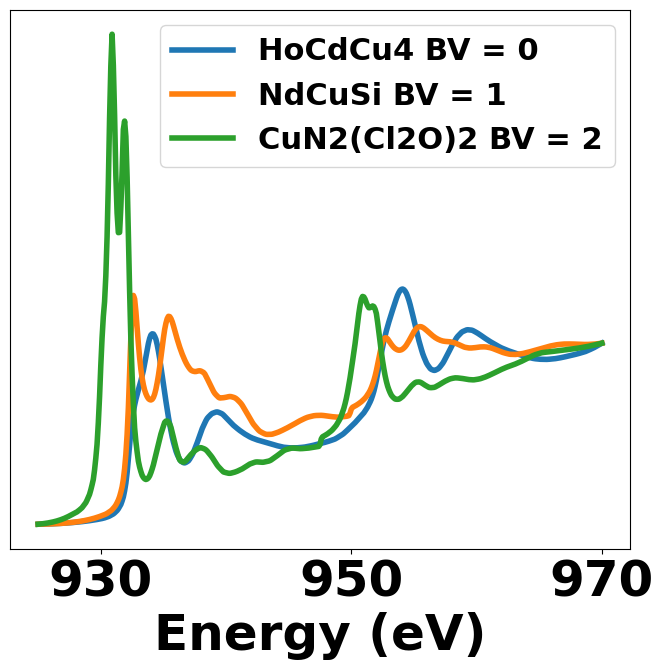

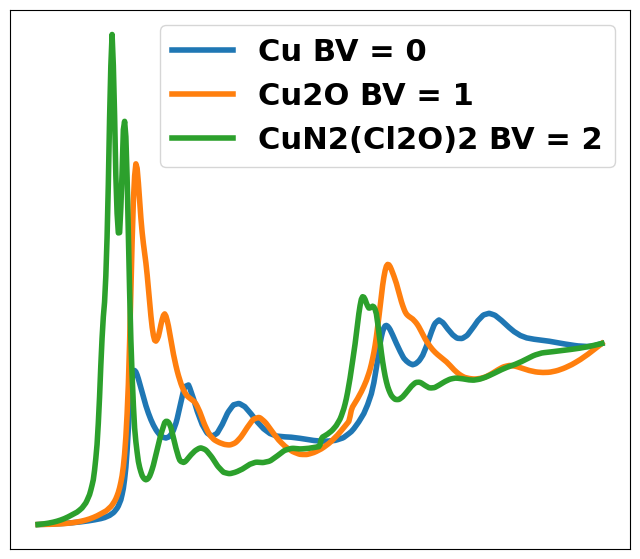

In [15]:
# visualize specific integer oxidation state spectra 
test_rf_obj.visualize_mixture_components('mp-30', 'mp-361', 'mp-704645', include_title=False, include_ticks = True, 
                                         savefigure=True)
test_rf_obj.visualize_mixture_components('mp-12007', 'mp-8120', 'mp-1188453', include_title=False, savefigure=False)
test_rf_obj.visualize_mixture_components('mp-30', 'mp-361', 'mp-1188453', include_title=False, include_ticks = False, 
                                         savefigure=False)

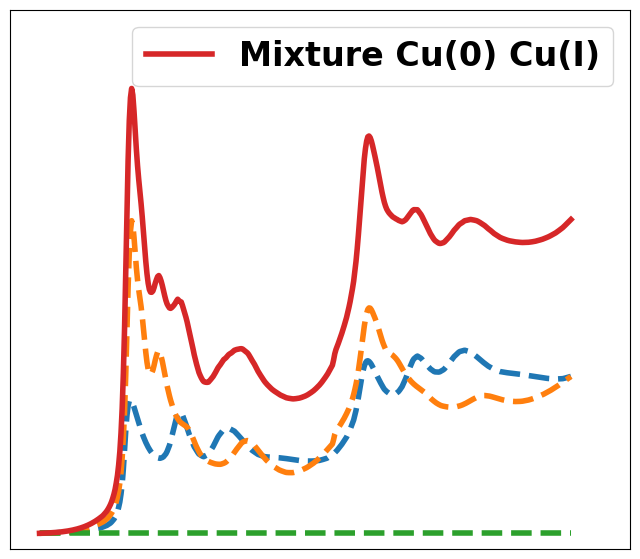

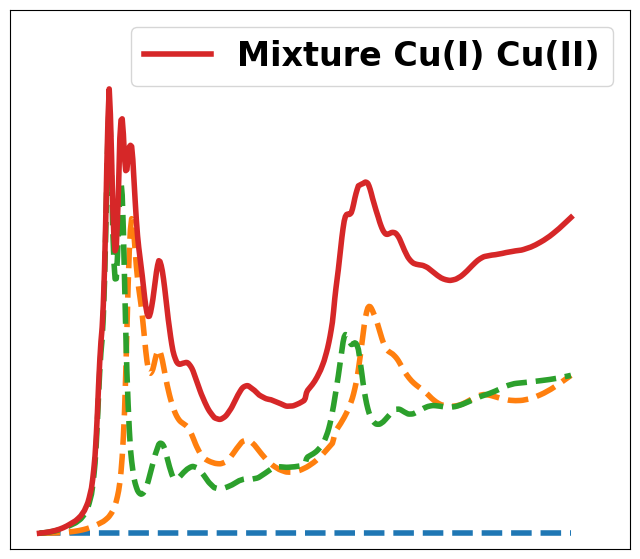

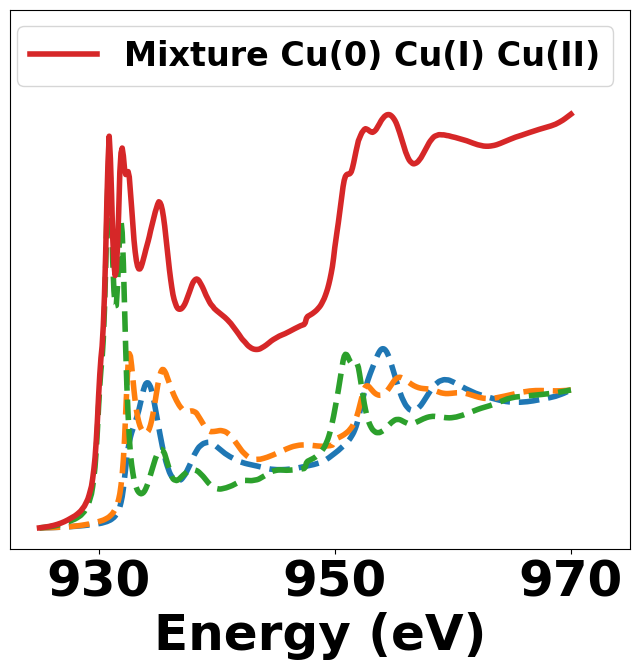

In [16]:
# visualize how integer valent spectra combine to make mixture datasets in the 3 different types of mixtures present in this 
# dataset: mixtures of Cu(0) and Cu(I), mixtures of Cu(I) and Cu(II) and mixtures of all three integer oxidation states 
test_rf_obj.visualize_mixtures('mp-30', 'mp-361', 'mp-1188453', 0.5, 0.5, 0.0, include_title = False, savefigure = False, 
                               include_ticks = False)
test_rf_obj.visualize_mixtures('mp-30', 'mp-361', 'mp-1188453', 0.0, 0.5, 0.5, include_title = False, savefigure = False)
test_rf_obj.visualize_mixtures('mp-12007', 'mp-8120', 'mp-1188453', 0.33, 0.33, 0.33, include_ticks = True, include_title = False,
                  savefigure = True)

<font size="6"> Validation on Experimental Samples. Figure 1 IV and Figure 3

Predicting From Cu_deconvolved_spectra\Cu Metal Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


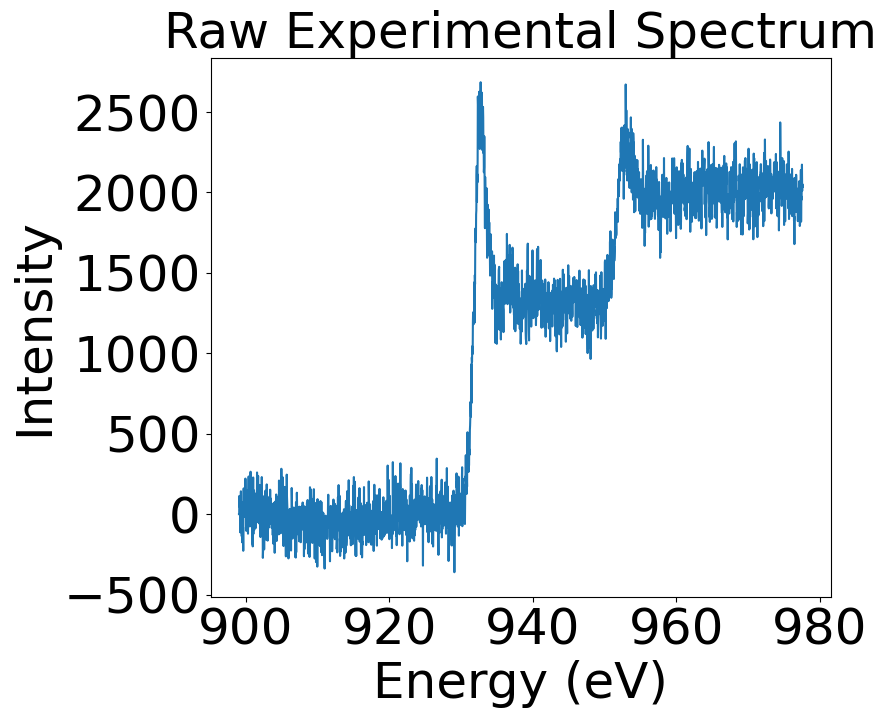

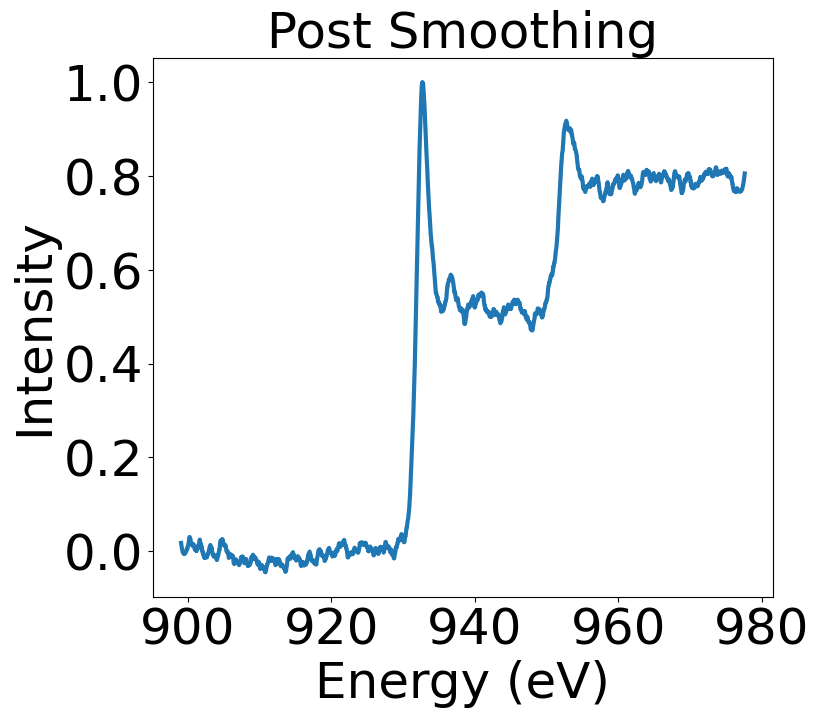

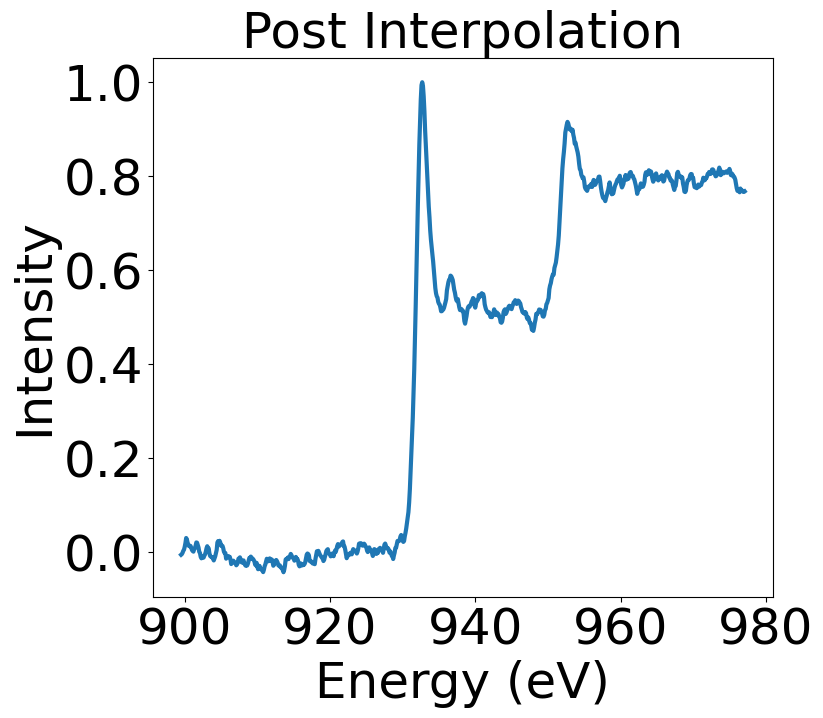

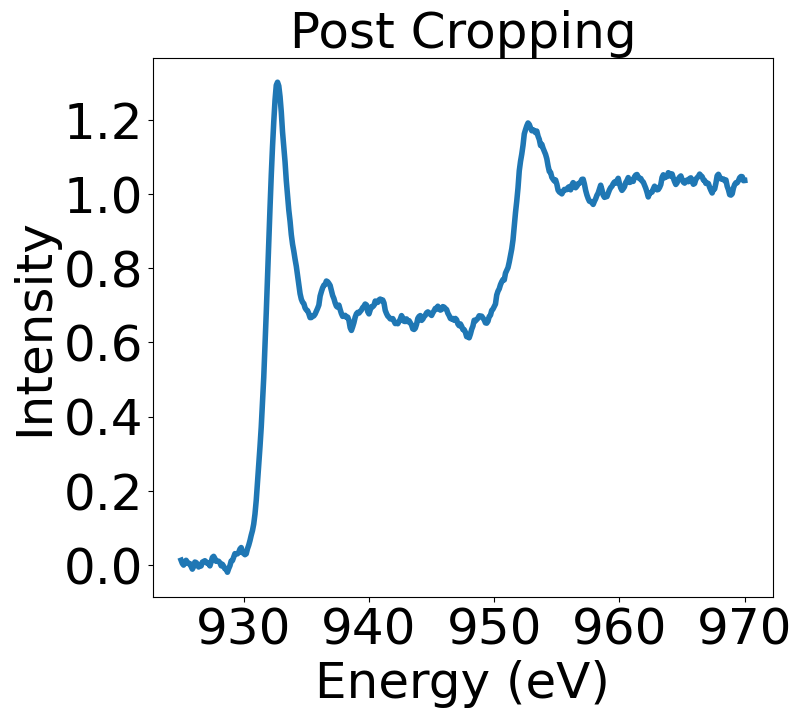

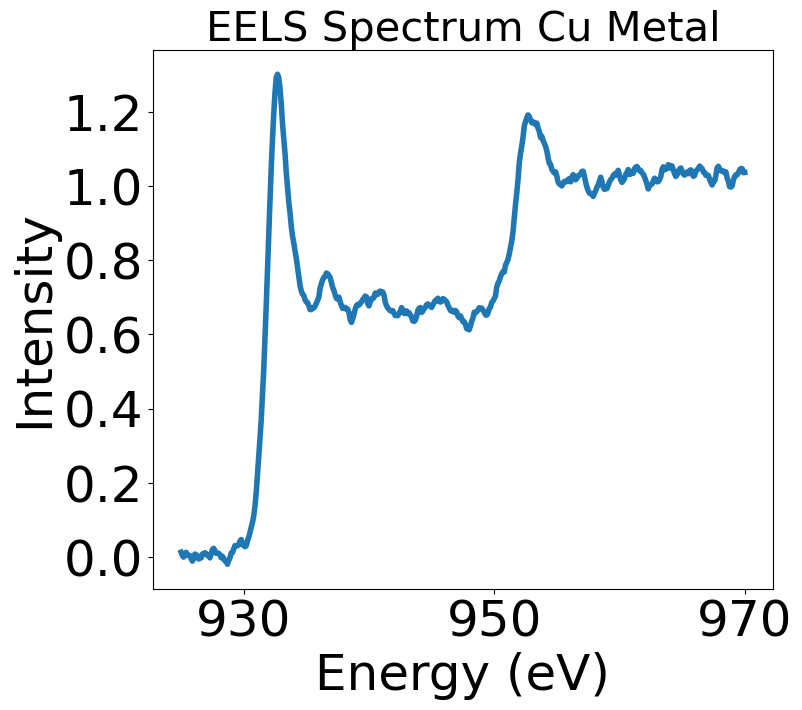

prediction = 0.3
prediction std = 0.35
 


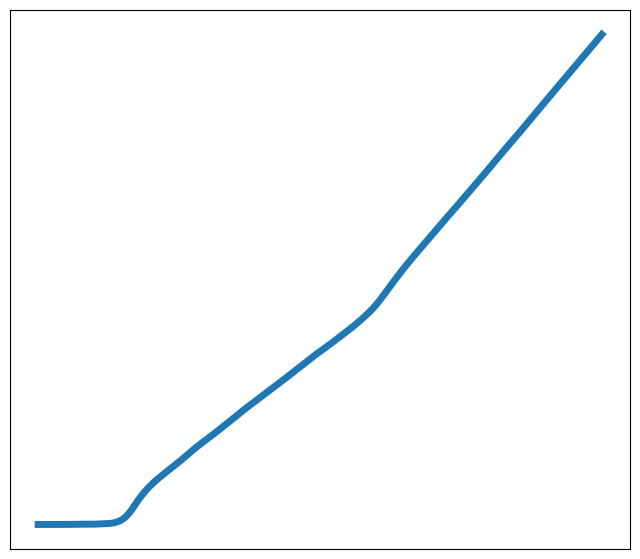

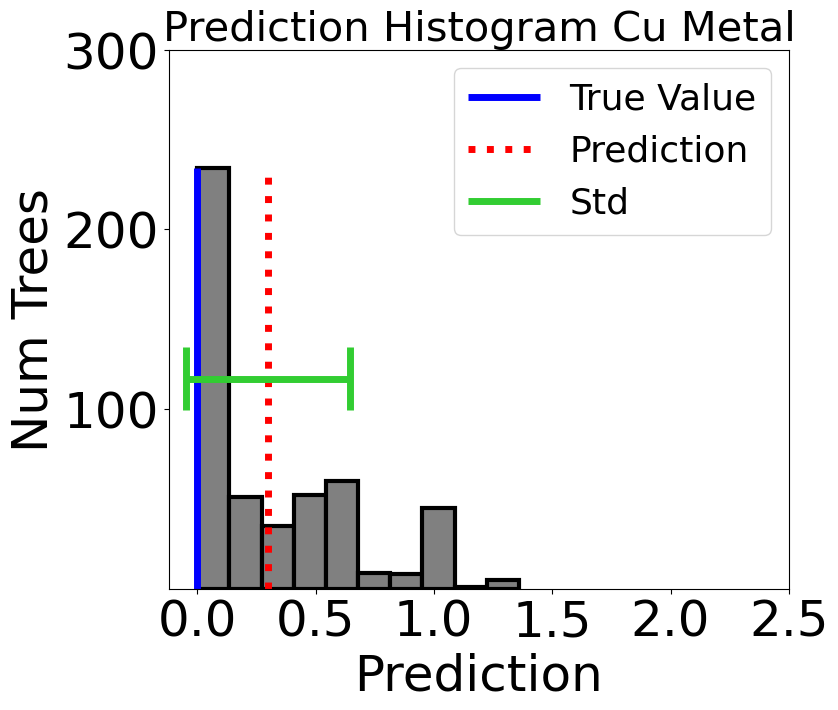

Predicting From Cu_deconvolved_spectra\Cu2O Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


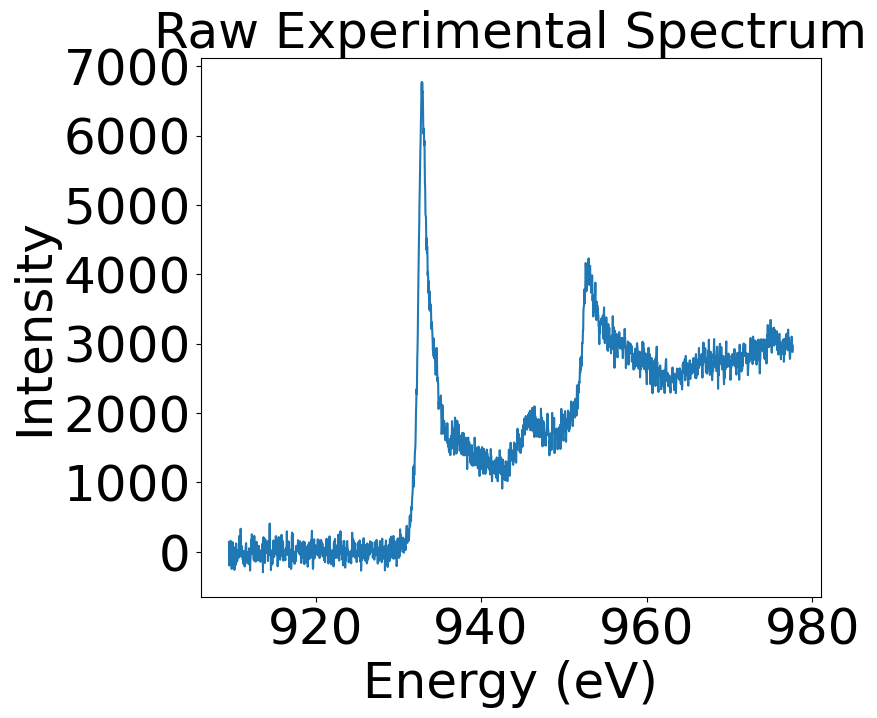

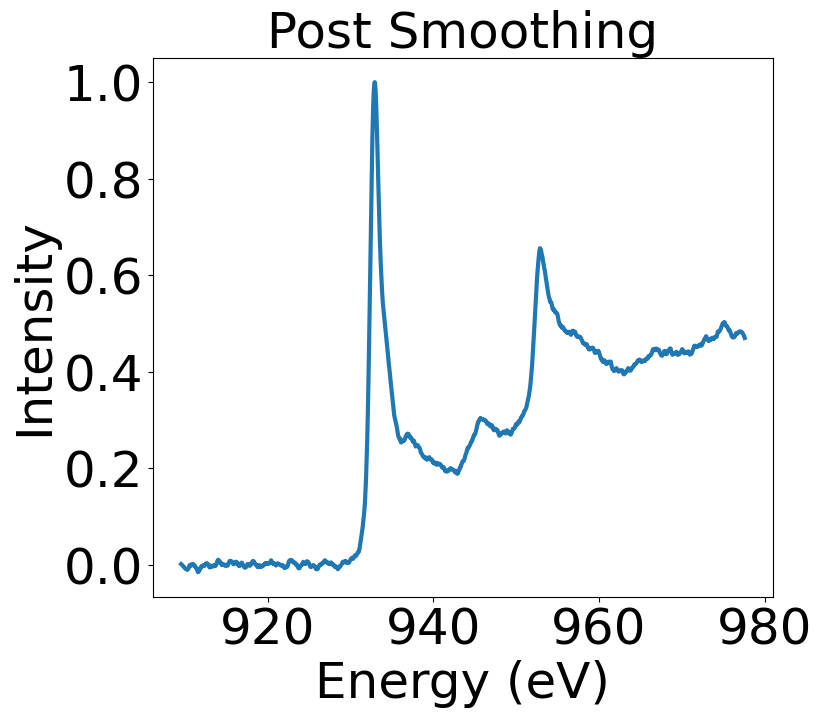

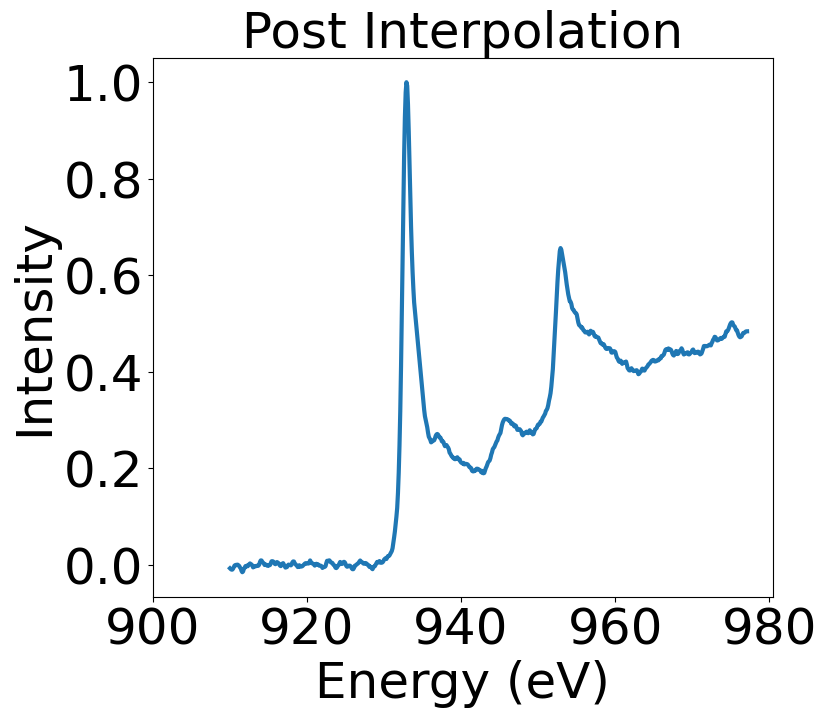

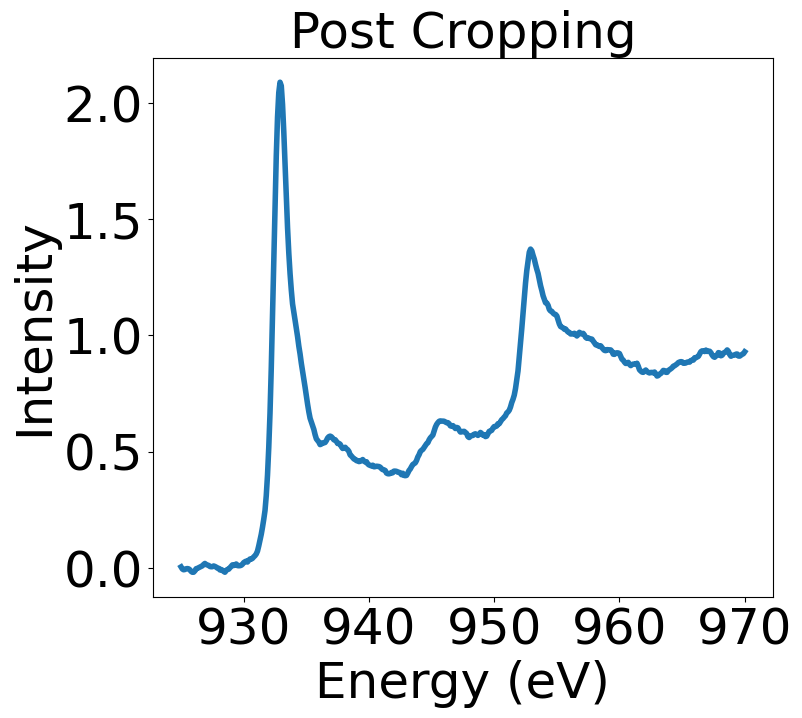

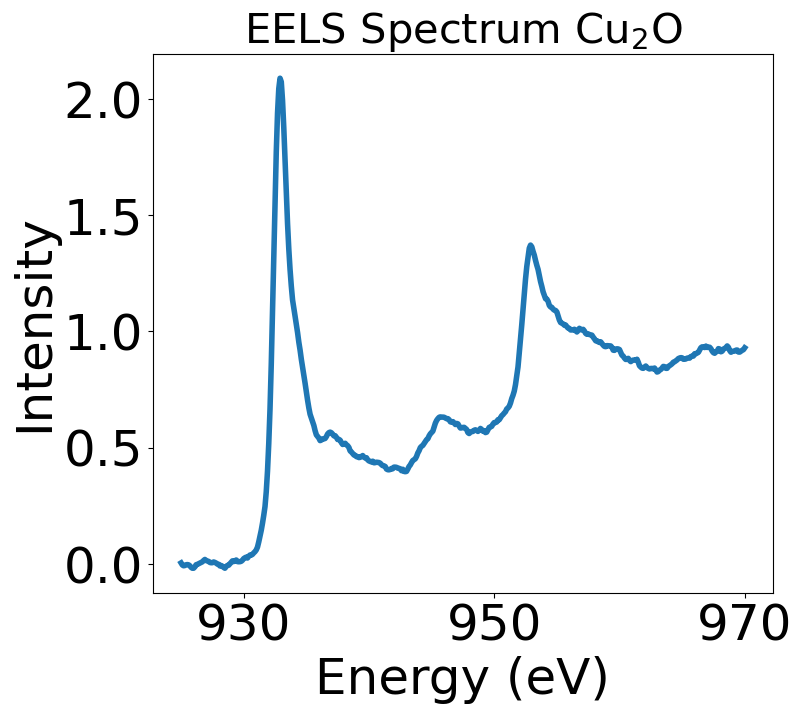

prediction = 1.07
prediction std = 0.18
 


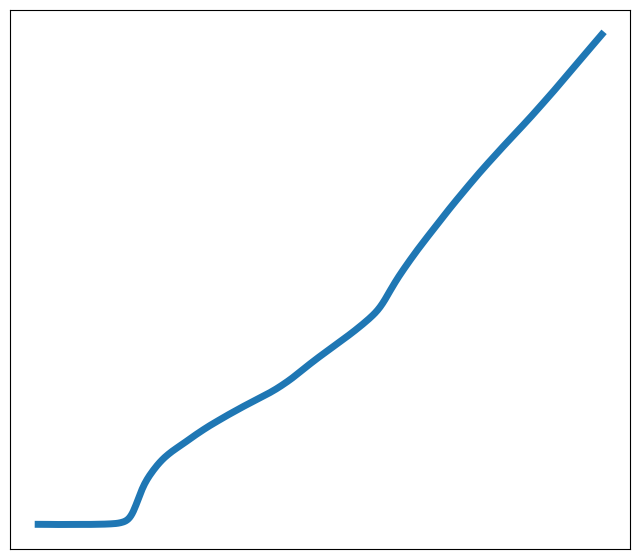

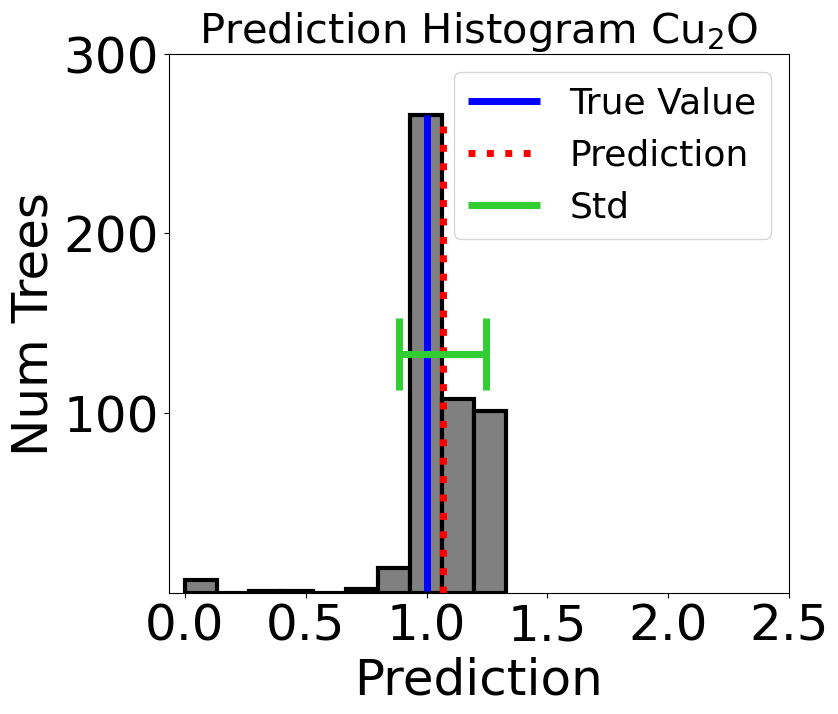

Predicting From Cu_deconvolved_spectra\CuO Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


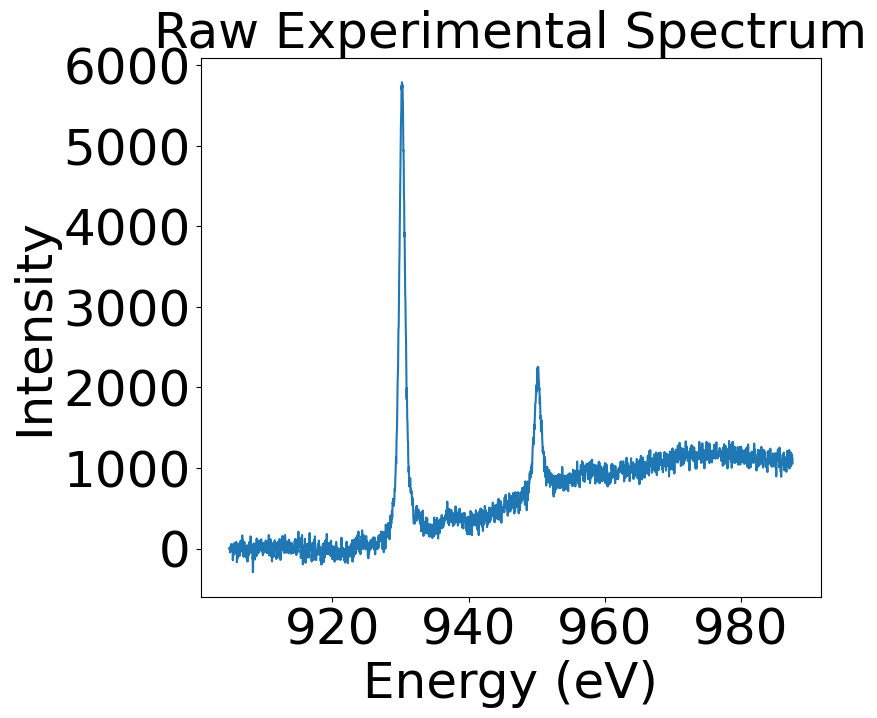

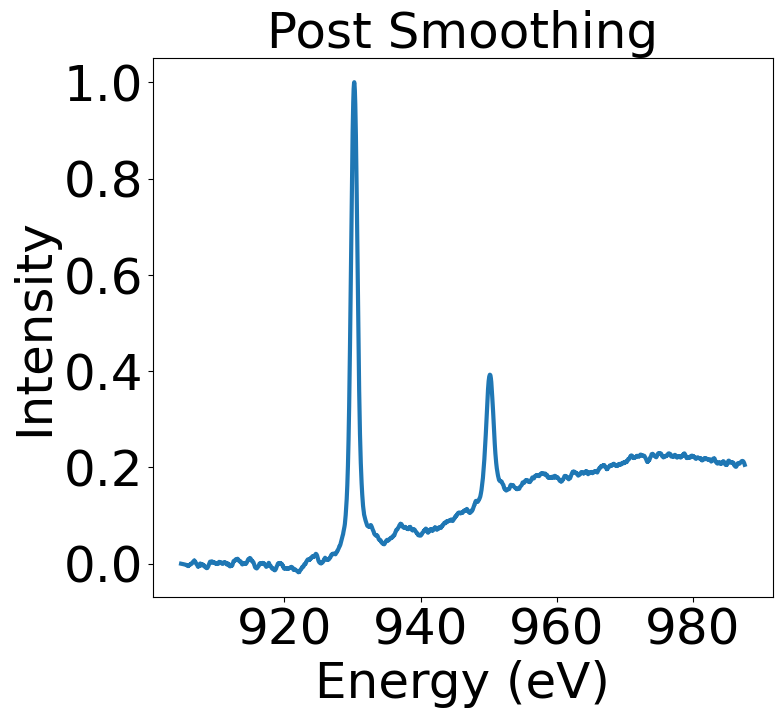

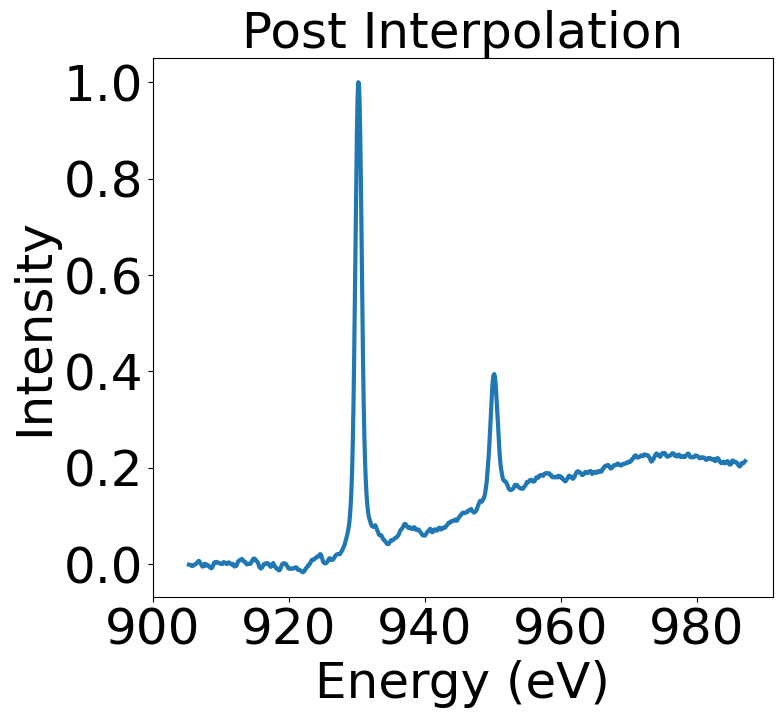

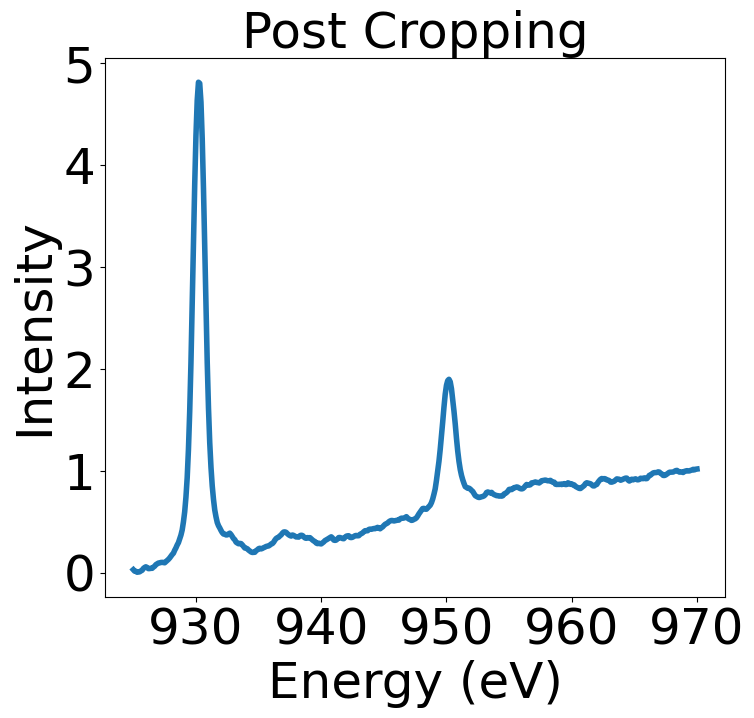

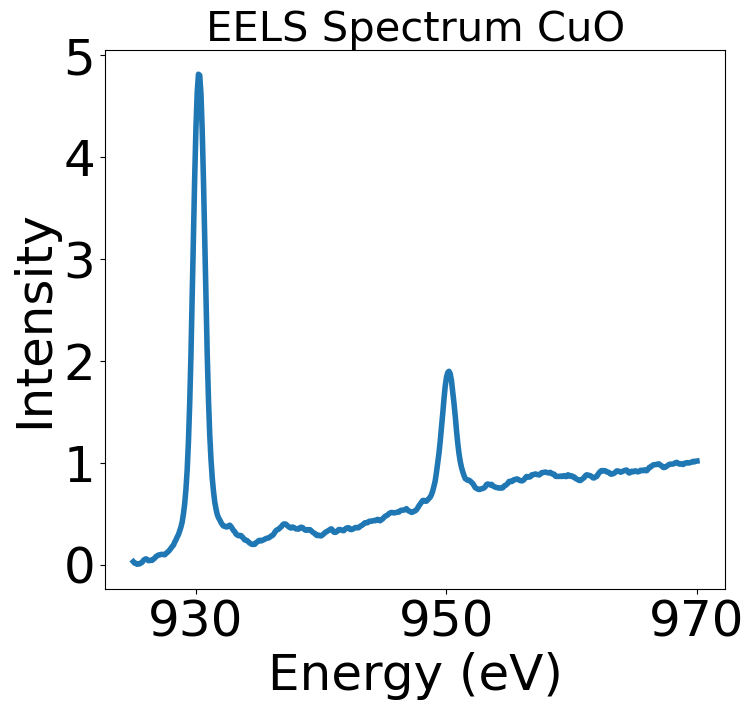

prediction = 2.12
prediction std = 0.21
 


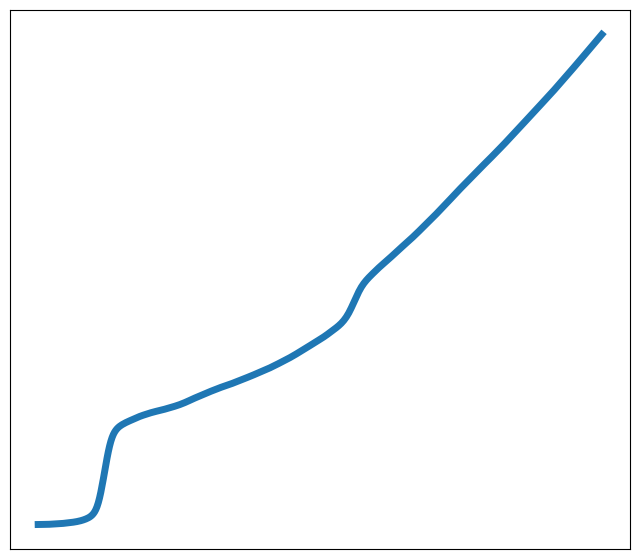

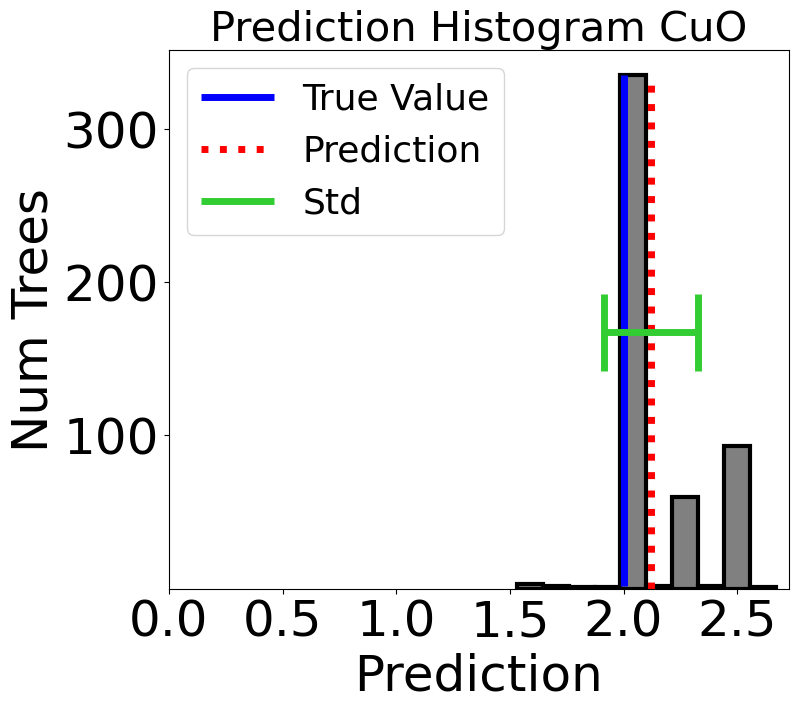

In [17]:
# predict the standards from the three experimental standards taken in this work
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = [0], theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]], 
                                      show_hist=True, show_inputted_spectrum=True, print_details = True, show_plots=True,
                                     savefigure=False, theory_indicies = [1644, 2246, 824])

<font size="6"> Visualize Energy Axis Shift For Experimental Samples. Figure 4

In [18]:
shifts = np.linspace(-1.5,1.5,31)

In [19]:
# shift the experimental spectra energy axis and visualize how that impacts prediction 
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]],
                                     print_details = False, theory_indicies = [1644, 2246, 824])

╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         1.9  │             0.42 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         1.83 │             0.43 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         1.8  │             0.45 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         1.74 │             0.48 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         1.73 │             0.49 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

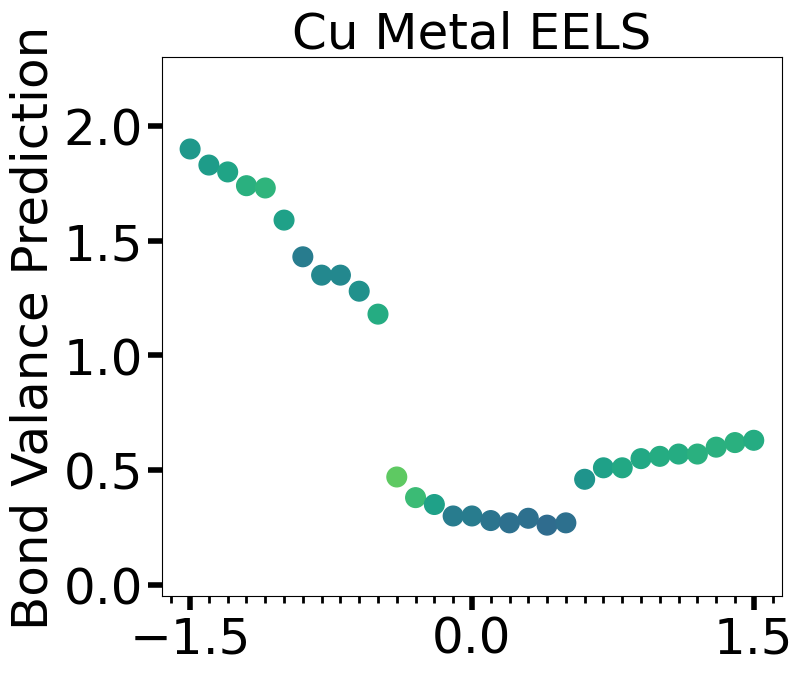

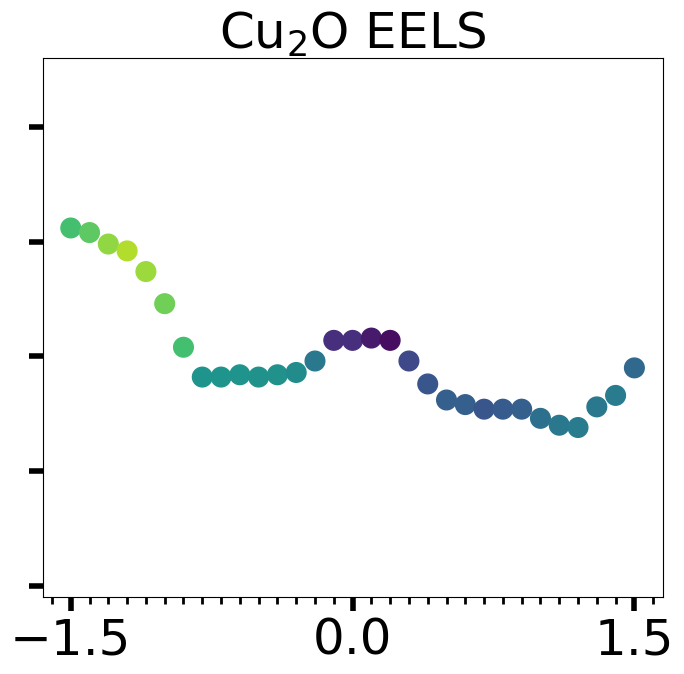

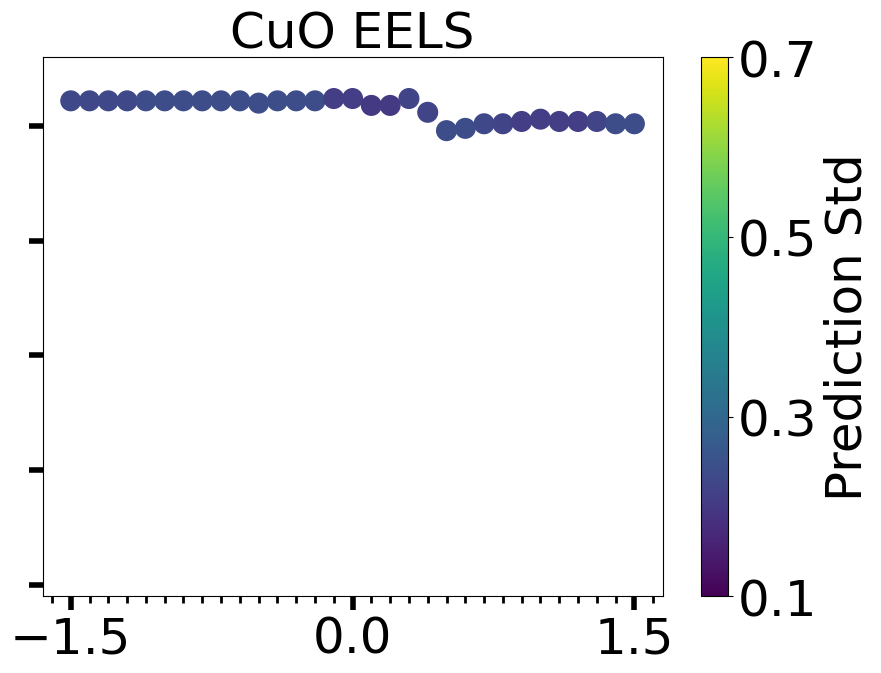

In [20]:
# must run the above cell before this visualization code will work
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = True, savefigure=False, spectrum_type = 'EELS')

In [21]:
# shift the literature spectra energy axis and visualize how that impacts prediction 
# smoothing window is 15 rather than 51 because the extracted literature spectra aren't on an even spacing and need to be 
# interpolated before they can be smoothed. Therefore they are interpolated to 0.1 eV spacing first and then smoothed, 
# so the smoothing window must be correspondingly adjusted to make sure the energy window size remains at 1.5 eV 
test_rf_obj.predict_experiment_folder('xas paper/', spectra_type = 'csv', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[15,3]],
                                     print_details = False, show_hist=False, show_plots=False, theory_indicies = [1644, 2246, 824])


╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         1.05 │             0.45 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         0.73 │             0.55 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         0.51 │             0.53 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         0.43 │             0.52 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         0.38 │             0.45 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

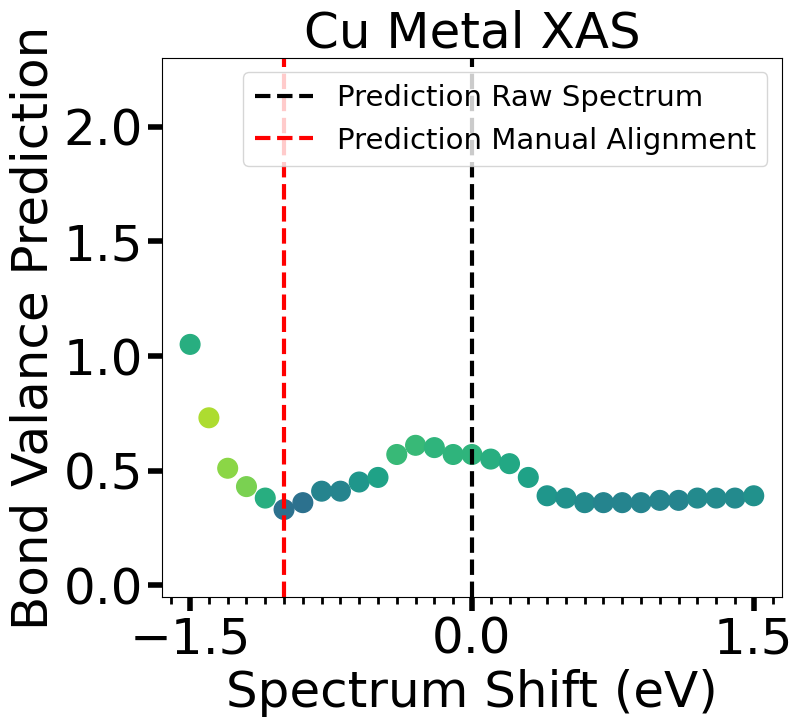

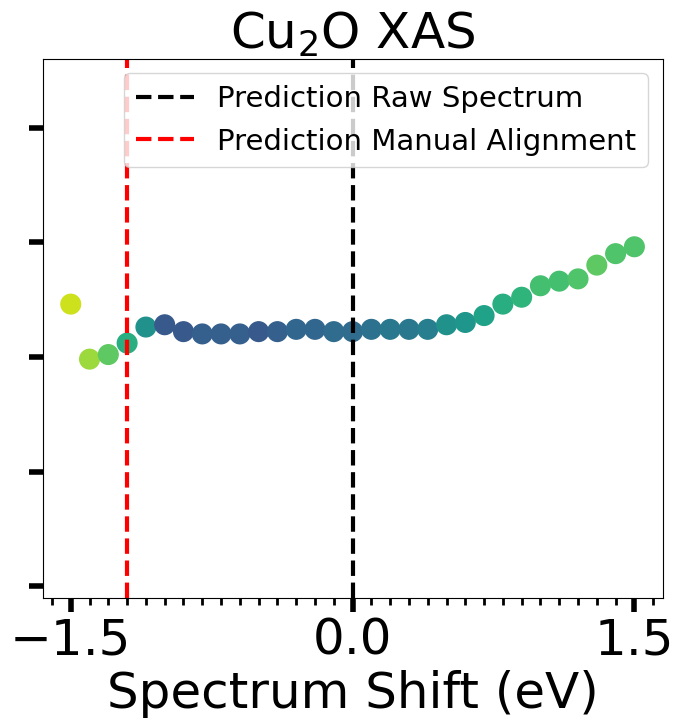

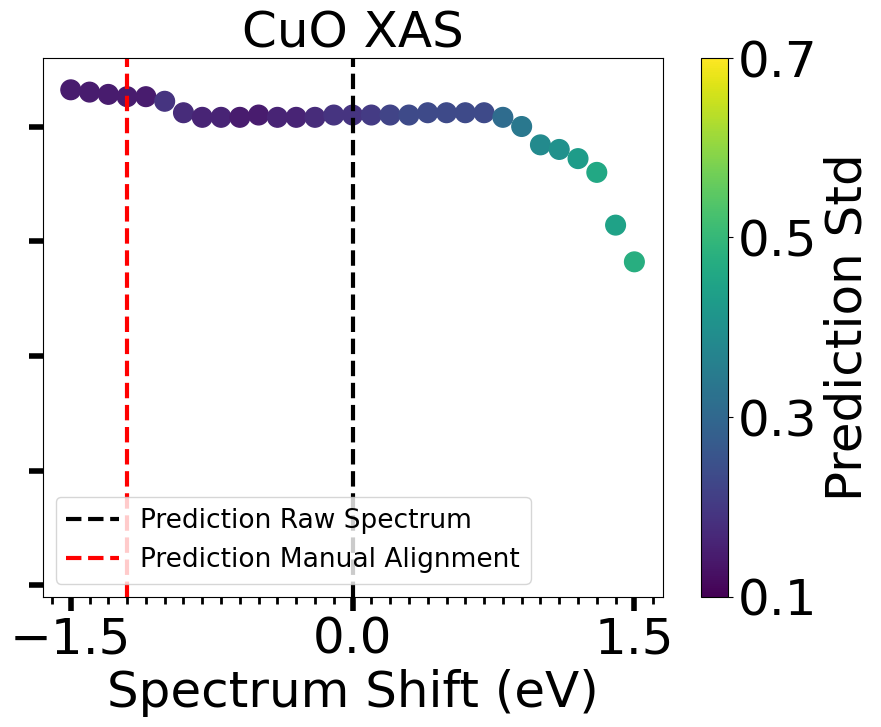

In [22]:
# must run the above cell before this visualization code will work
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = True, savefigure=False, show_shift_labels = True,
                                     shift_labels = [-1, -1.2, -1.2], spectrum_type = 'XAS')

<font size="6"> Predict Experimental Mixtures. Figure 5

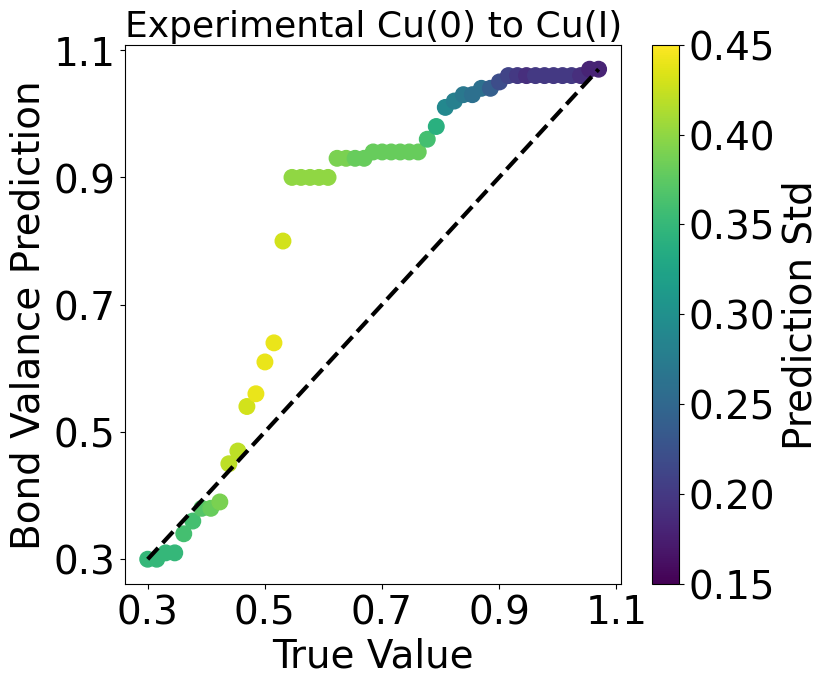

In [23]:
# predict experimental mixtures of Cu(0) and Cu(I) and Cu(I) and Cu(2)  
test_rf_obj.experimental_mixed_valent(catagory = '0-1', colorbar_range = [0.15, 0.45], savefigure = False)

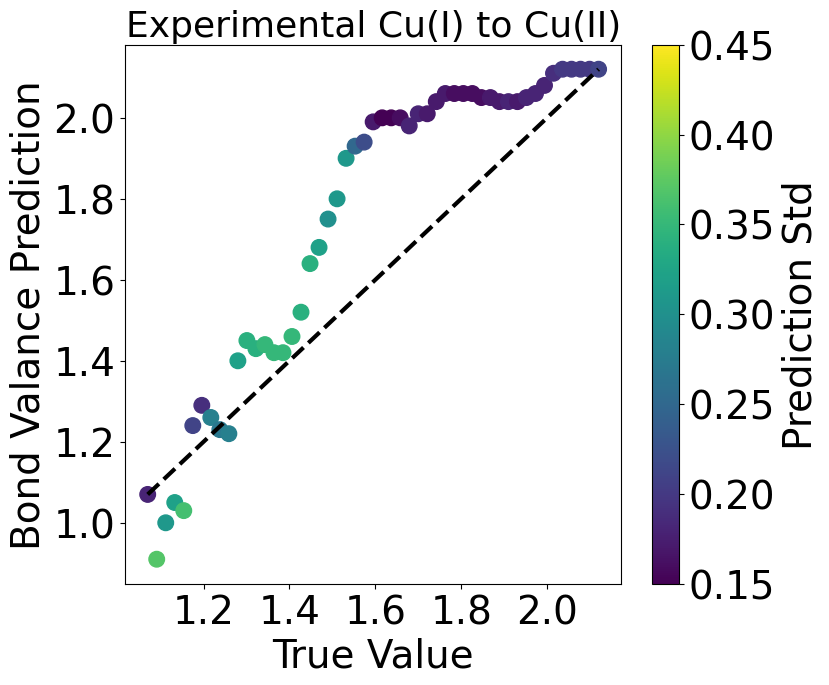

In [24]:
test_rf_obj.experimental_mixed_valent(catagory = '1-2', colorbar_range = [0.15, 0.45], savefigure = False)

<font size="6"> Augment Test Set With Noise and Predict Noisy Spectra. Figure 6

In [10]:
# interpolate test set so spectra are on a 0.03 eV spacing, the same as our experimental standards 
test_rf_obj.add_interp_spec_to_ERROR_df([0.03], False,925)

0.03


0


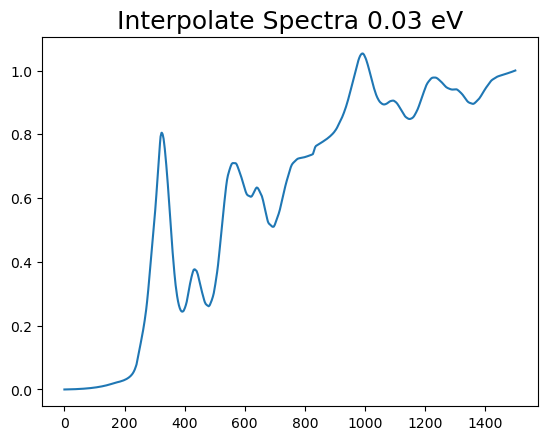

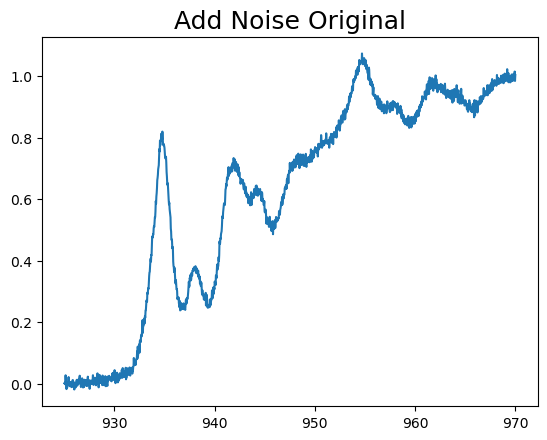

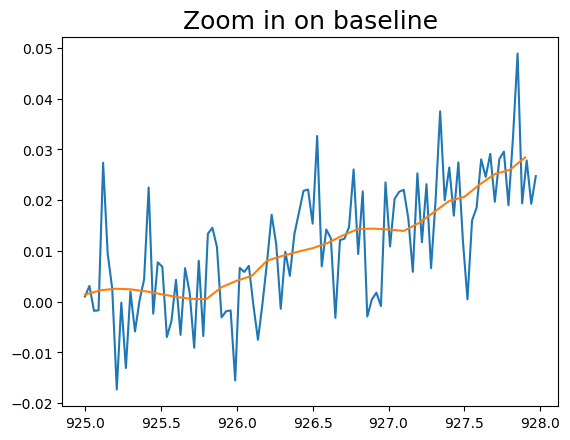

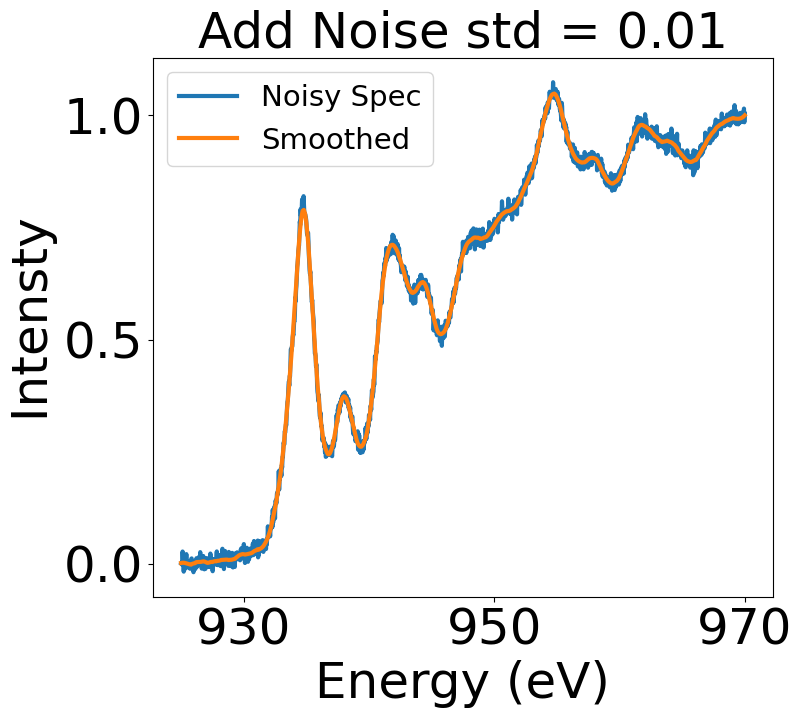

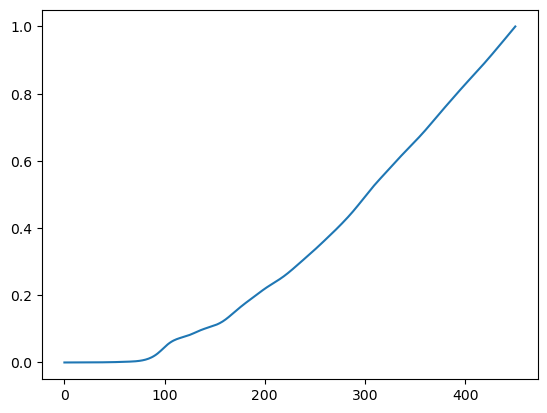

model accuracy (R^2) on simulated test data 0.8664514681756252
0.228776422721066


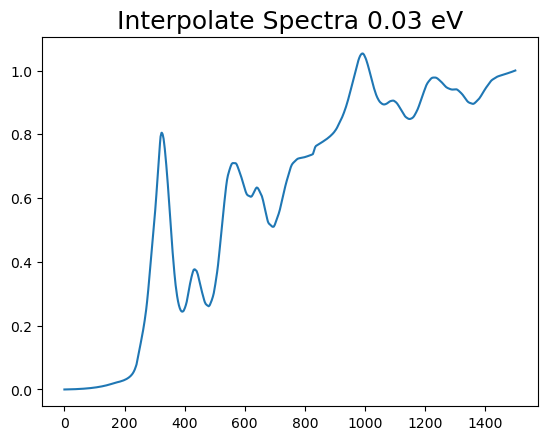

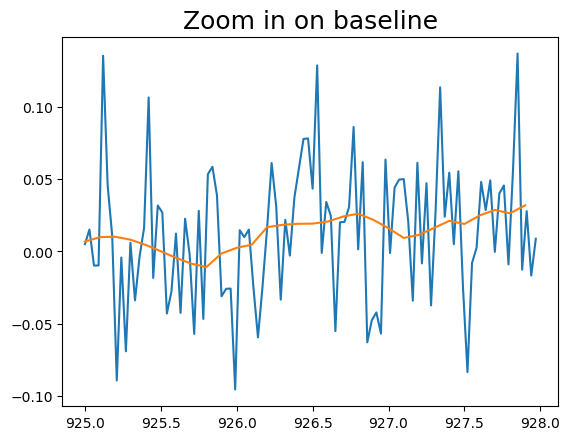

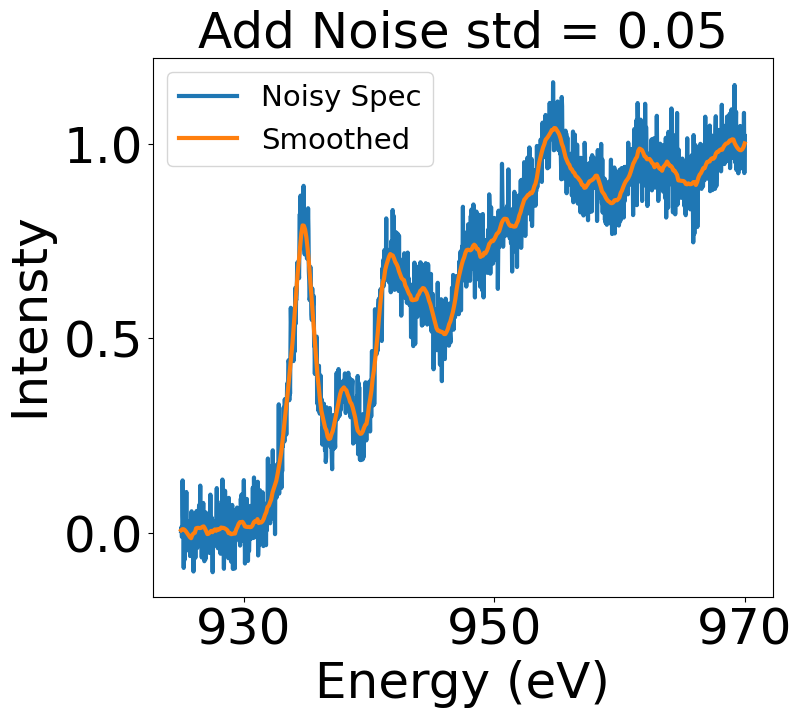

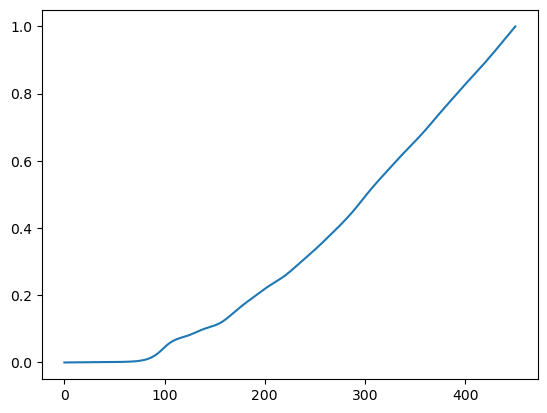

model accuracy (R^2) on simulated test data 0.8059453654840871
0.2757742521232258


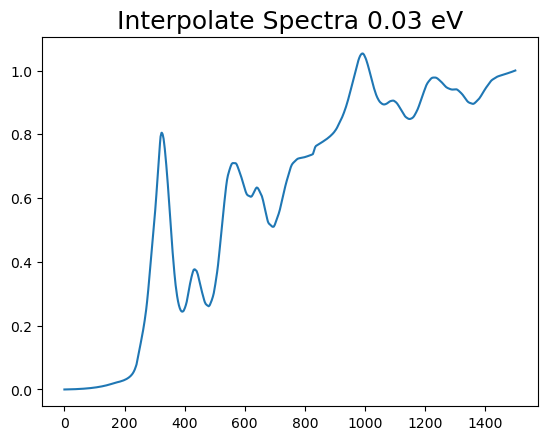

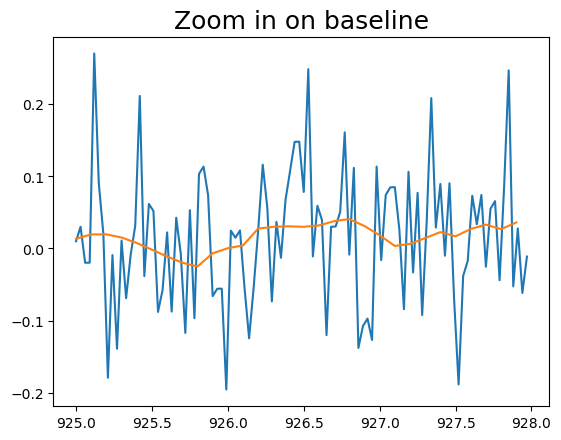

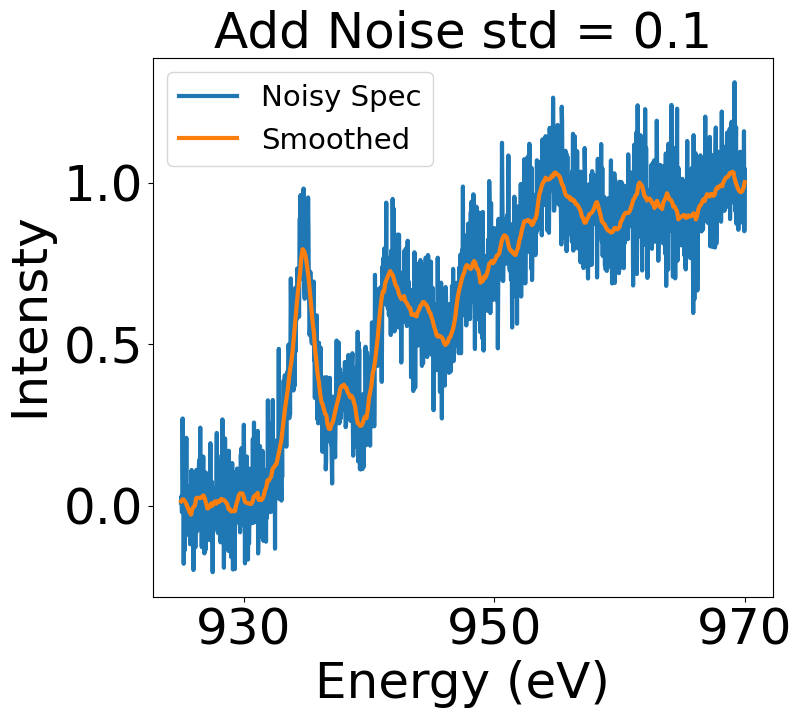

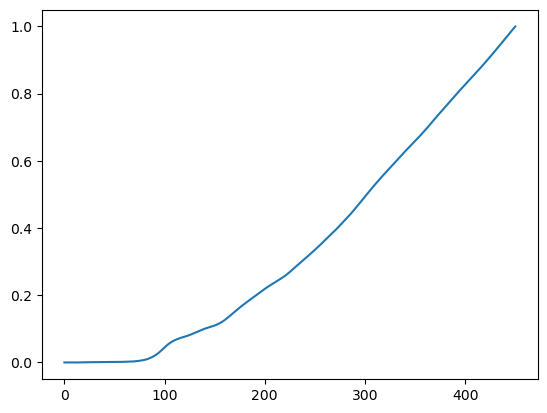

model accuracy (R^2) on simulated test data 0.7890828607728448
0.2875064829165312


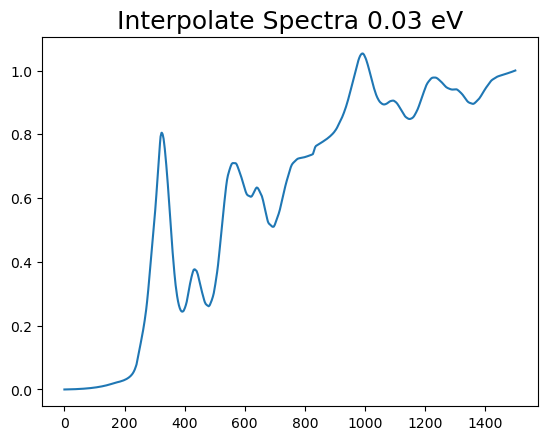

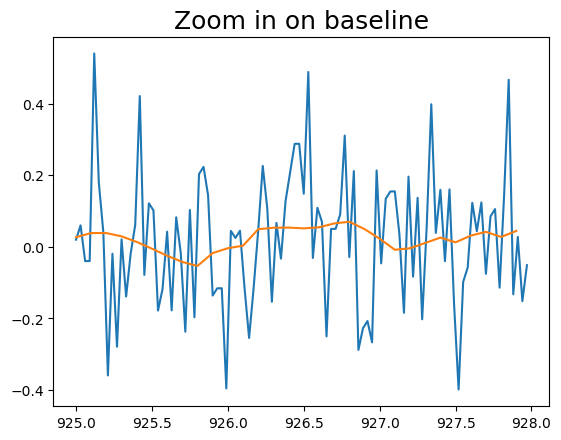

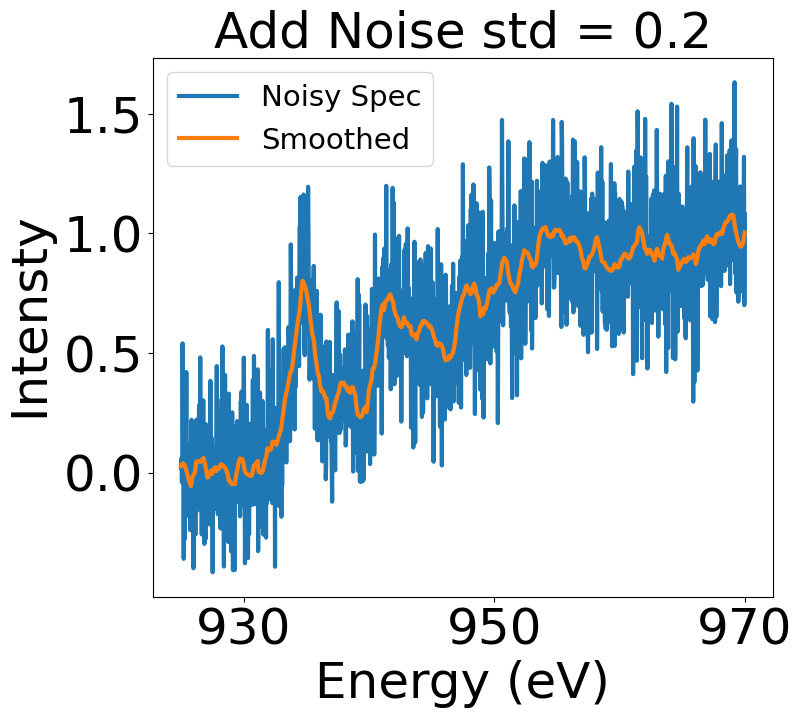

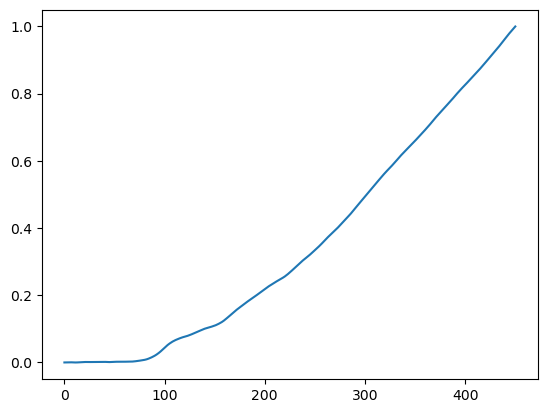

model accuracy (R^2) on simulated test data 0.7780883325867132
0.29490475438184355
1
model accuracy (R^2) on simulated test data 0.7925392999028698
0.28514097181757586
model accuracy (R^2) on simulated test data 0.6087356193286875
0.3915857348257637
model accuracy (R^2) on simulated test data 0.5691991961477062
0.4108941502037237
model accuracy (R^2) on simulated test data 0.5456881355077668
0.4219575336586326
2
model accuracy (R^2) on simulated test data 0.8210358502966415
0.26483460154787963
model accuracy (R^2) on simulated test data 0.6346246330383707
0.3784088964156061
model accuracy (R^2) on simulated test data 0.5811271732574531
0.40516581881610175
model accuracy (R^2) on simulated test data 0.5404961295404727
0.42436180969337917
3
model accuracy (R^2) on simulated test data 0.7128773721029248
0.33544816151127915
model accuracy (R^2) on simulated test data 0.4971985140359072
0.4439049441109991
model accuracy (R^2) on simulated test data 0.4595381738578532
0.46022925117300983
mod

model accuracy (R^2) on simulated test data 0.45046642306355744
0.46407569369163365
model accuracy (R^2) on simulated test data 0.43537489875832425
0.4704048562858333
26
model accuracy (R^2) on simulated test data 0.825472753183727
0.2615310905253964
model accuracy (R^2) on simulated test data 0.6673564808432626
0.3610615474641793
model accuracy (R^2) on simulated test data 0.6373942563156517
0.37697195805431544
model accuracy (R^2) on simulated test data 0.5887528926247391
0.4014607891757461
27
model accuracy (R^2) on simulated test data 0.8277024354620118
0.2598551181560178
model accuracy (R^2) on simulated test data 0.7903275146804566
0.286656918110841
model accuracy (R^2) on simulated test data 0.7669248198348146
0.3022314955276025
model accuracy (R^2) on simulated test data 0.6849848600958905
0.35136412680884055
28
model accuracy (R^2) on simulated test data 0.8435601765818236
0.24760839462019985
model accuracy (R^2) on simulated test data 0.7942888963919319
0.28393607393280107
mo

model accuracy (R^2) on simulated test data 0.7839908324795993
0.29095632154742807
model accuracy (R^2) on simulated test data 0.7707290856337348
0.2997548284011608
model accuracy (R^2) on simulated test data 0.742692405751894
0.3175543073977141
51
model accuracy (R^2) on simulated test data 0.8197463134792871
0.2657870296639787
model accuracy (R^2) on simulated test data 0.7769410382170003
0.29566610772366975
model accuracy (R^2) on simulated test data 0.7470669357783459
0.31484333828735434
model accuracy (R^2) on simulated test data 0.6970198568334824
0.34458692066641533
52
model accuracy (R^2) on simulated test data 0.8687506980968365
0.22679851516463229
model accuracy (R^2) on simulated test data 0.8334338391416953
0.25549658155694144
model accuracy (R^2) on simulated test data 0.7953442439835869
0.2832068071203828
model accuracy (R^2) on simulated test data 0.7337640198560768
0.32301677700868764
53
model accuracy (R^2) on simulated test data 0.8467281879558209
0.24508845369540153


model accuracy (R^2) on simulated test data 0.828385232506708
0.25933971784035037
model accuracy (R^2) on simulated test data 0.7868325752450291
0.28903612432279796
model accuracy (R^2) on simulated test data 0.7588754472976287
0.30740605910185065
model accuracy (R^2) on simulated test data 0.6807368898459402
0.3537252611619092
76
model accuracy (R^2) on simulated test data 0.5383715310313909
0.42534173473096054
model accuracy (R^2) on simulated test data 0.4697906878139315
0.45584309584550364
model accuracy (R^2) on simulated test data 0.4572720765936935
0.4611930873457614
model accuracy (R^2) on simulated test data 0.44313187522177866
0.4671624050636734
77
model accuracy (R^2) on simulated test data 0.8592014957077141
0.23490417006017025
model accuracy (R^2) on simulated test data 0.8171654565027119
0.26768302516884407
model accuracy (R^2) on simulated test data 0.7979228409161891
0.2814169939808706
model accuracy (R^2) on simulated test data 0.7677337274945657
0.30170657936008777
78

model accuracy (R^2) on simulated test data 0.6219390860798917
0.3849218778080307


In [58]:
# generate full simulated noise analysis. This takes a very long time to run 
test_rf_obj.full_noise_setup('Interpolated_spec_0.03', 'Interpolated_spec_energies_0.03', 0.03, 51, 
                             filename='Dataset_generation/reproducable_alignment_model_full_noise_df_poisson_03.joblib',
                            show_plots = True)

In [11]:
# load the values generated by the cell above 
poisson_noise_df_03 = joblib.load('Dataset_generation/reproducable_alignment_model_full_noise_df_poisson_03.joblib')

R2s
0.7979555711126739 0.7249104915485627 0.6904136598338433 0.6367088480864971
RMSEs
0.27505007552790106 0.32097265541870185 0.3418594688170294 0.37213596454471953


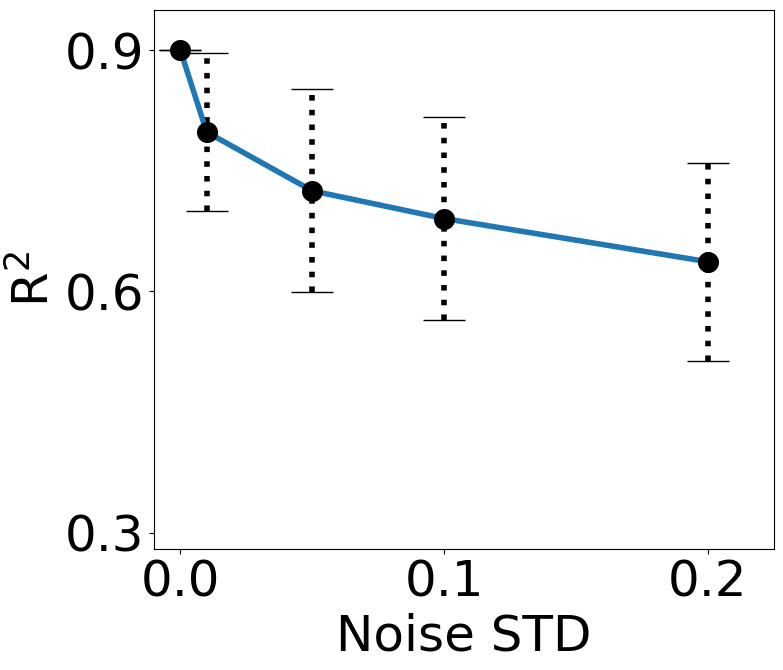

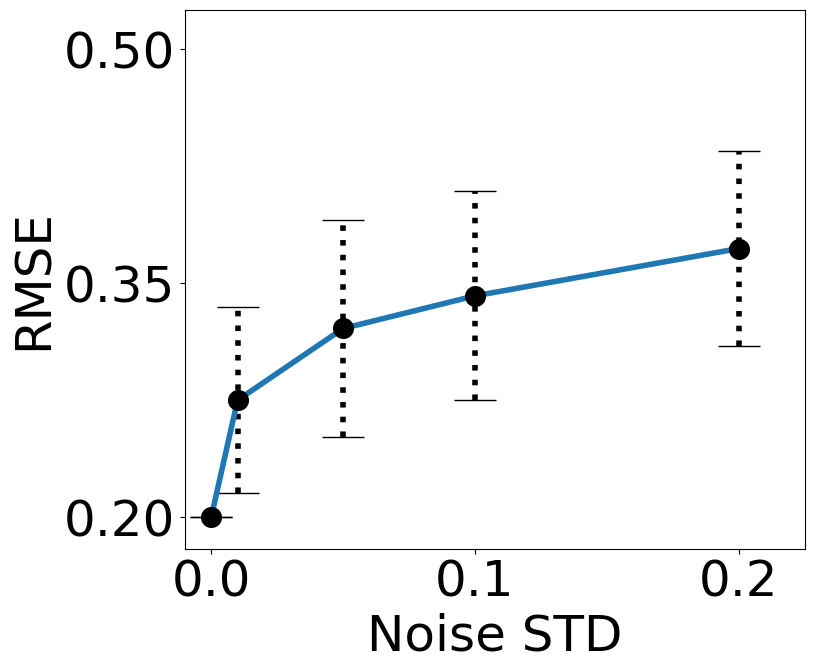

In [12]:
# plot the change in accuracy across different volumes of noise, with dotted bars showing standard deviation across 100 random 
# seeds for the noise profile generation 
visualize_full_noise_test_set([poisson_noise_df_03], [0.03], savefigure=False)

<font size="6"> Comparison between literature XAS and simulated XAS spectra for Cu metal, Cu2O and CuO. Figure S1

In [25]:
Cu_metal_path = "xas paper/Cu Metal XAS.csv"
Cu2O_path = "xas paper/Cu2O XAS.csv"
CuO_path = "xas paper/CuO XAS.csv"

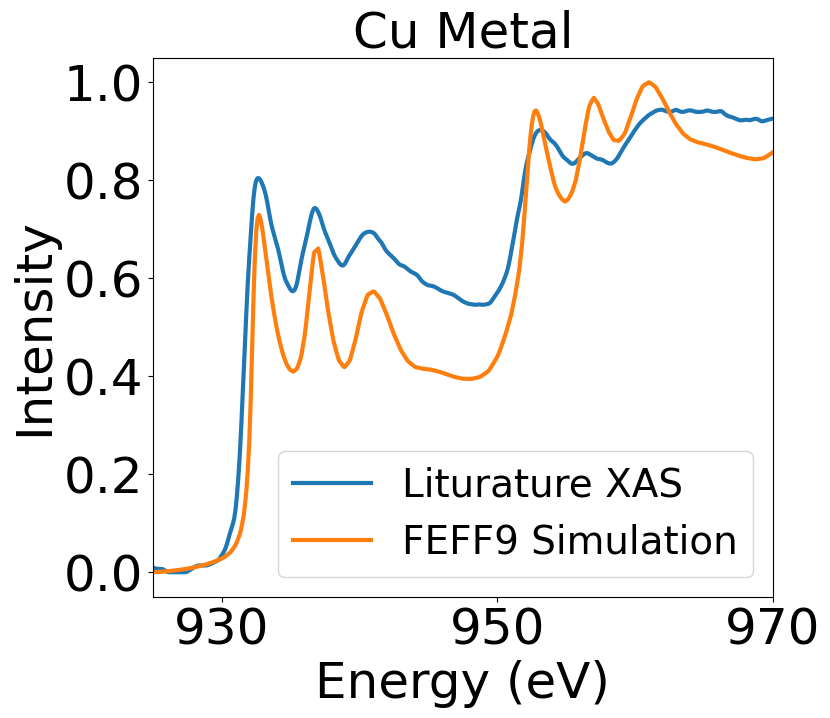

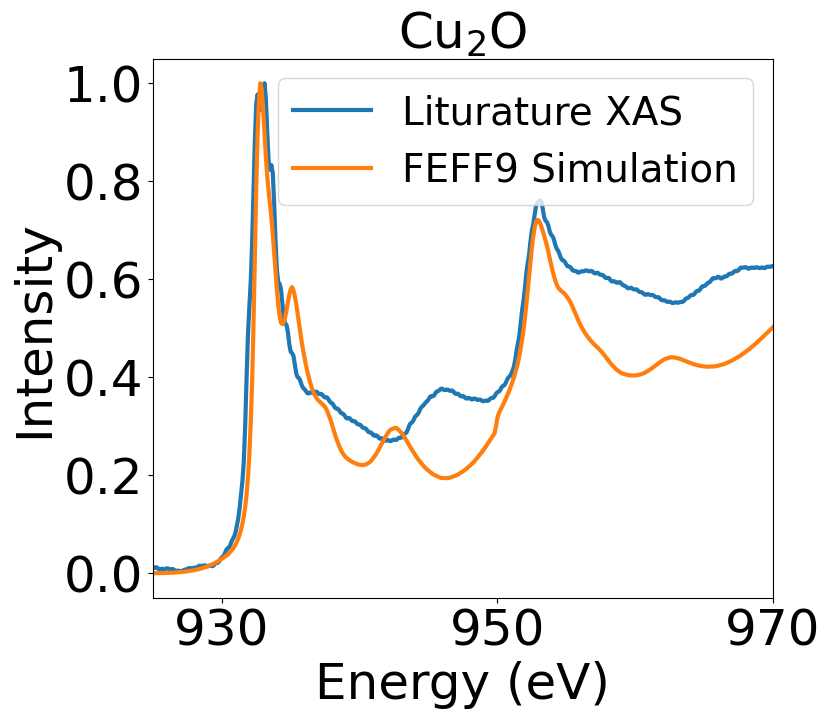

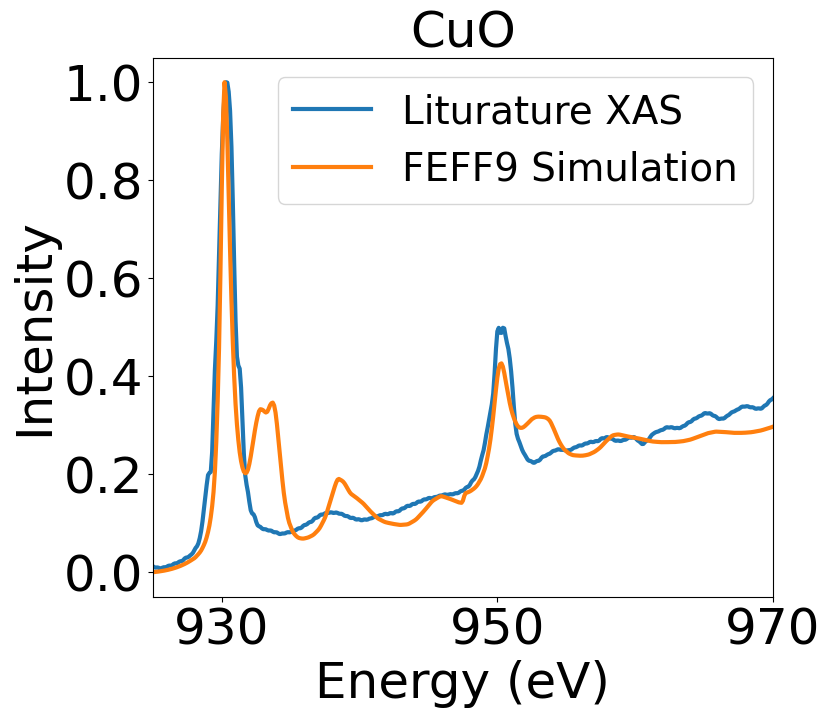

In [27]:
test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0, material = 'Cu metal',
                           compare_to_lit = True, lit_spectrum = Cu_metal_path, lit_shift = -1.0, xlims = [925,970],
                            title = 'Cu Metal', show_experiment = False, savefigure=False)

test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0, material = 'Cu2O',
                           compare_to_lit = True, lit_spectrum = Cu2O_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'Cu$_2$O', show_experiment = False, savefigure=False)


test_rf_obj.compare_simulation_to_experiment(show_feff = True, feff_shift = 0,
                           compare_to_lit = True, lit_spectrum = CuO_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'CuO', show_experiment = False, material = 'CuO',
                                            savefigure=False)

<font size="6"> Illustration of L2 and L3 Combination Into L2,3. Figure S2

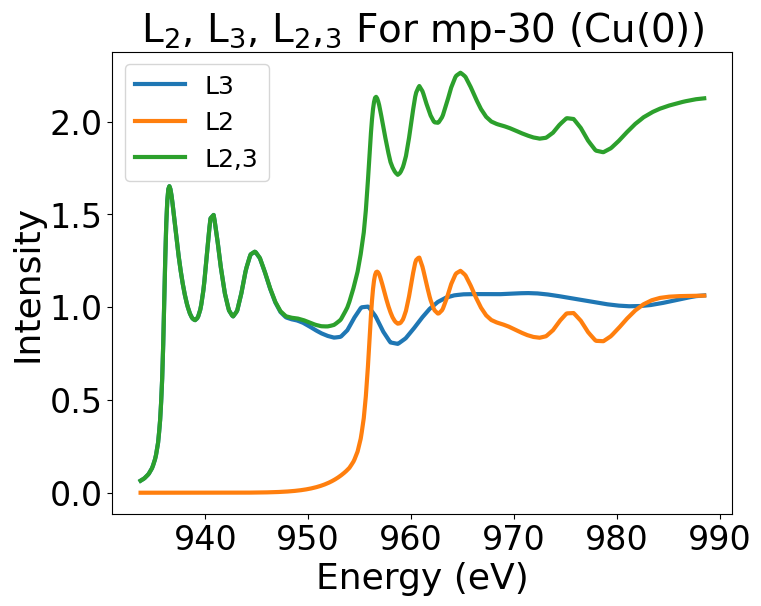

In [28]:
l2 = np.loadtxt('C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L2/mp-30/FEFF/000_Cu/xmu.dat',usecols=[0,3])
l3 = np.loadtxt('C:/Users/smgls/Materials_database/Stable_and_exp_Cu/Stable_and_exp_Cu/Stable_Cu_L3//mp-30/FEFF/000_Cu/xmu.dat',usecols=[0,3])

l2_3 = build_L2_3(l3, l2, savefigure=False)

<font size="6"> Illustration of The Generation of The Standardized Pre Edge Region Ensuring All Spectra Start at the same point and at Zero Intensity. Figure S3

interp min = 933.8


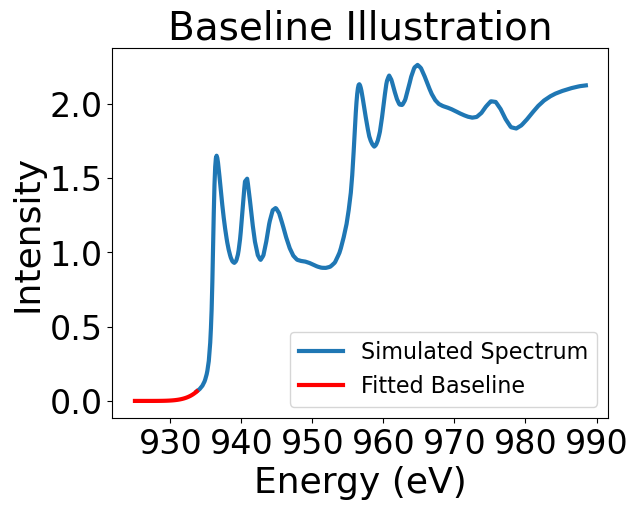

In [29]:
with open('scaled_baseline_example.pkl', 'rb') as f:
    ex_df = pickle.load(f)

ex_df = scale_spectra_flex(ex_df.loc[ex_df.mp_id == 'mp-30'], zero_energy = 925, show_plot=True, savefigure=False)

<font size="6"> R2 Plot of integer valence spectra used to build the mixture dataset. Figure S5

Accuracy = 0.9783432171456129
RMSE = 0.12009770586468121
num spectra = 543
model accuracy (R^2) on simulated test data 0.9015603378827061
RMSE 0.12009770586468121


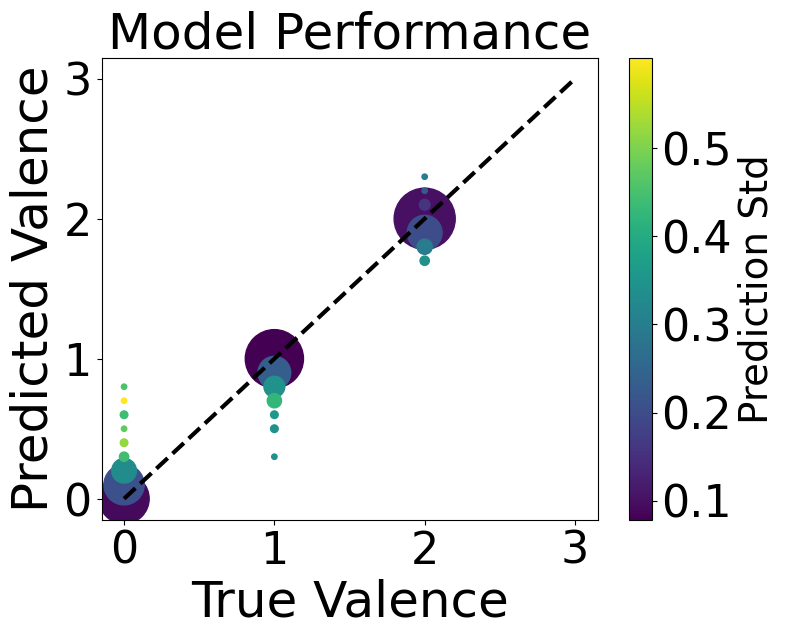

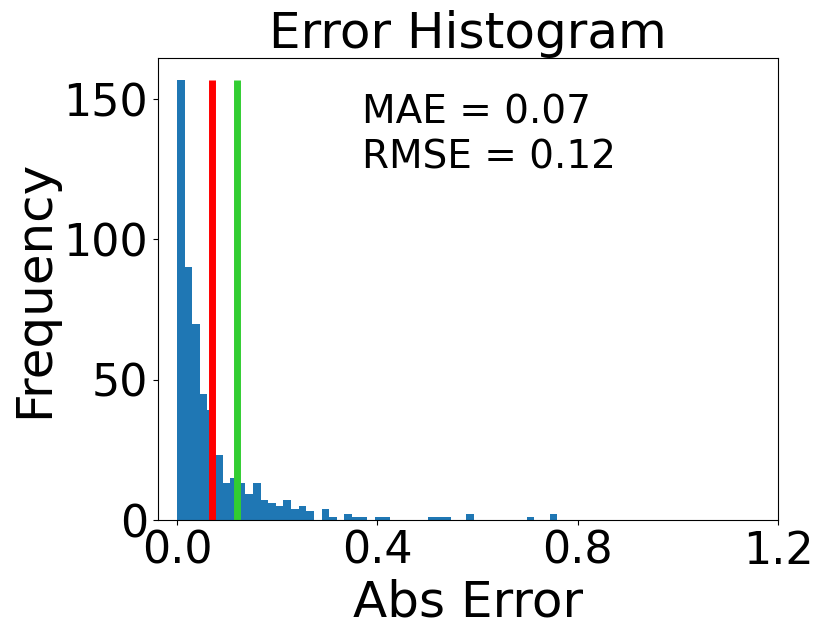

In [30]:
test_rf_obj.show_mixture_samples_accuracy(savefigure=False)

<font size="6"> Standard Deviation Thresholds. Figure S6

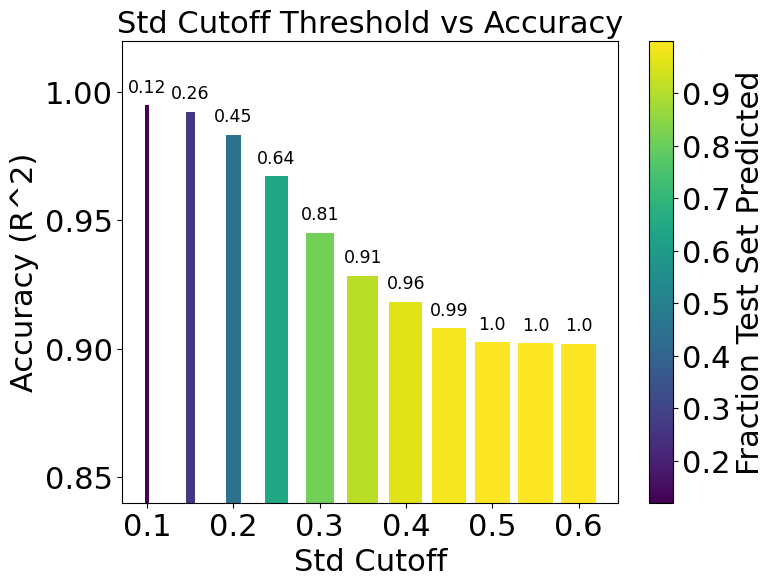

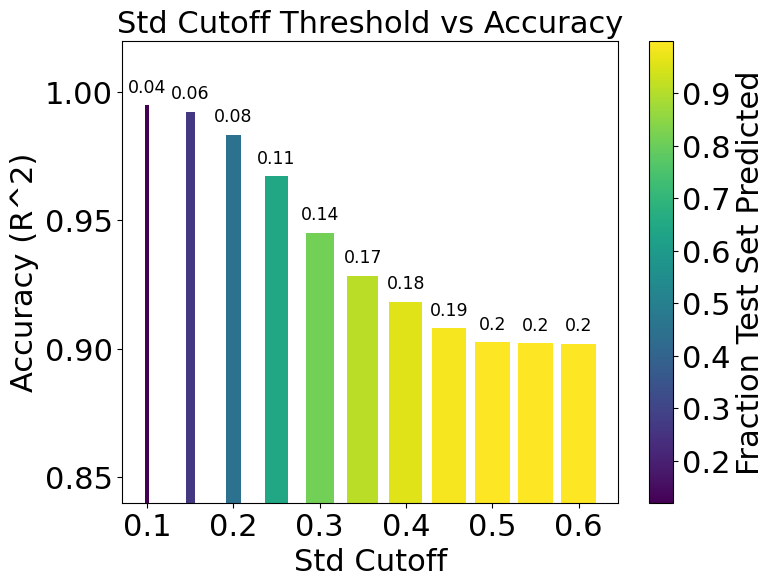

In [31]:
thresholds = np.arange(0.1, 0.65, 0.05)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.84, 1.02], text_fontsize = 12.5, show_type = 'percentage_predicted', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=False)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.84, 1.02], text_fontsize = 12.5, show_type = 'RMSE', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=False)

<font size="6"> Full Experimental Workflow. Figure S7

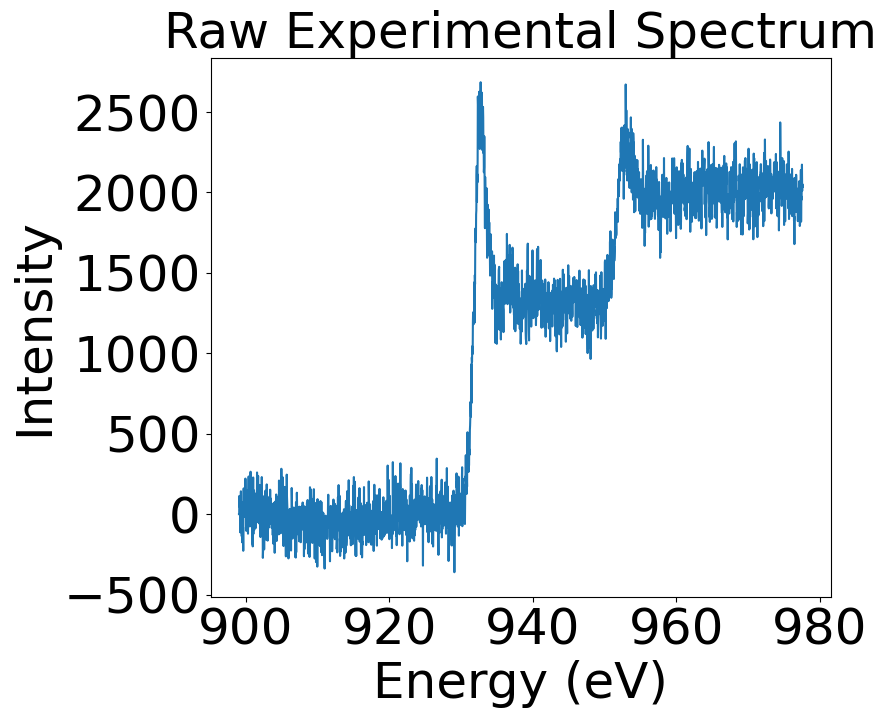

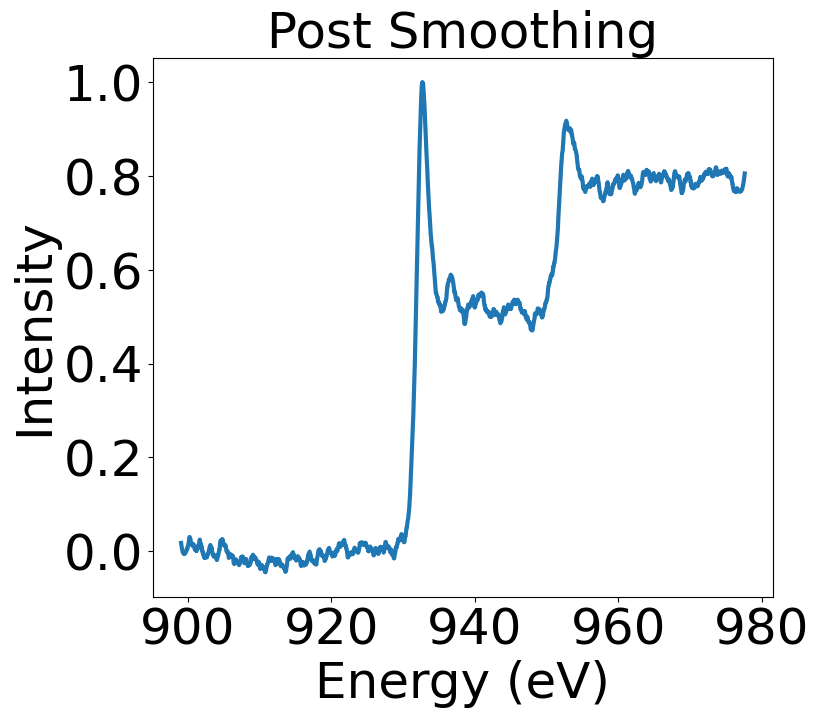

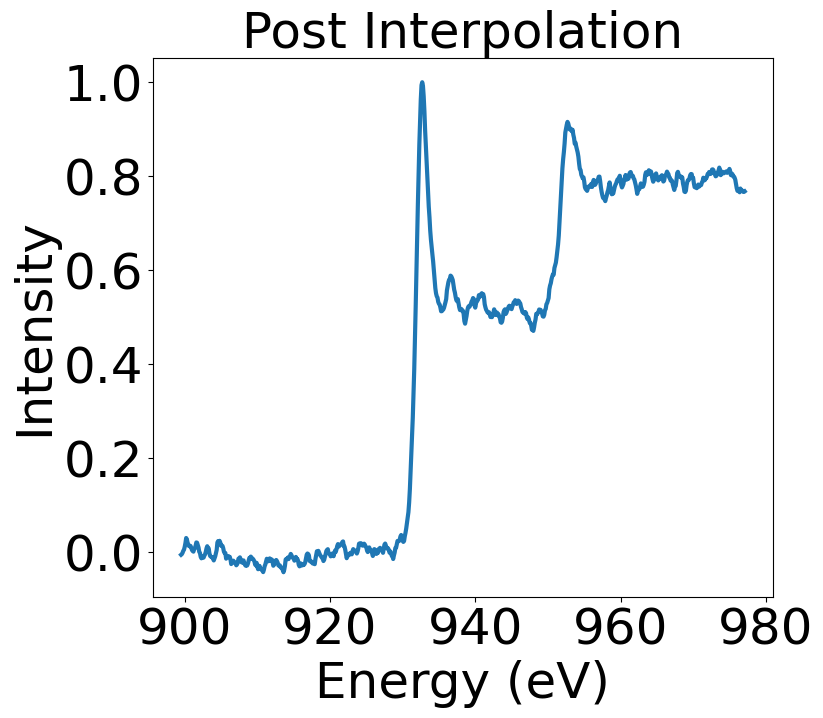

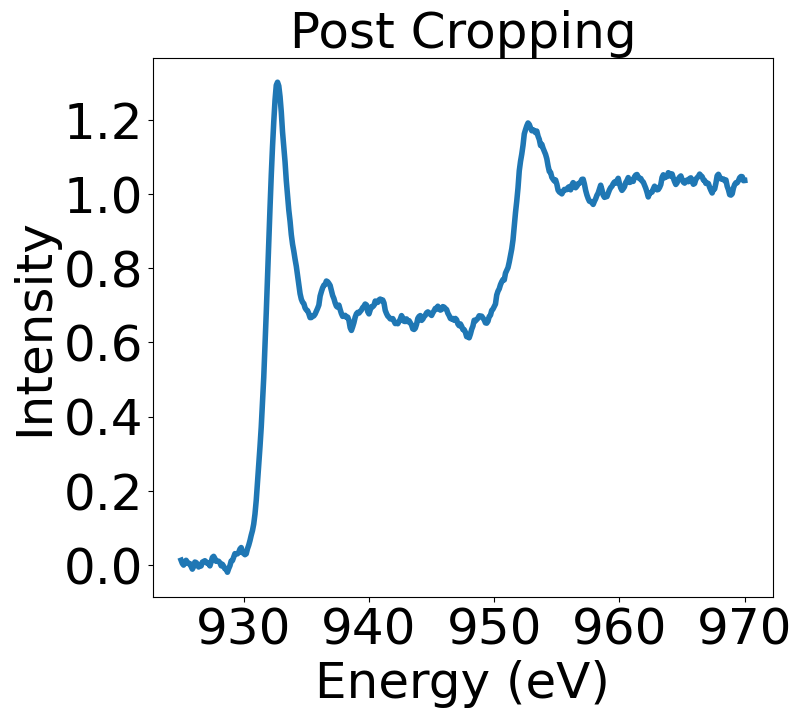

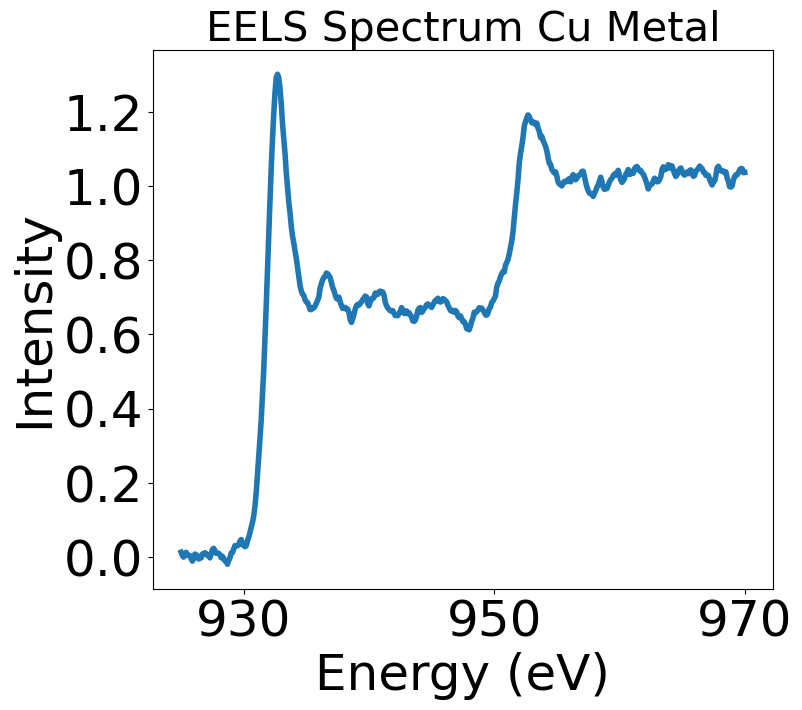

prediction = 0.3
prediction std = 0.35
 


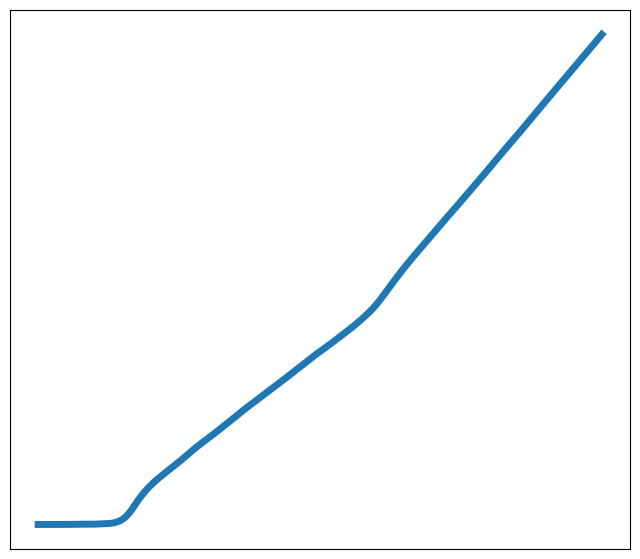

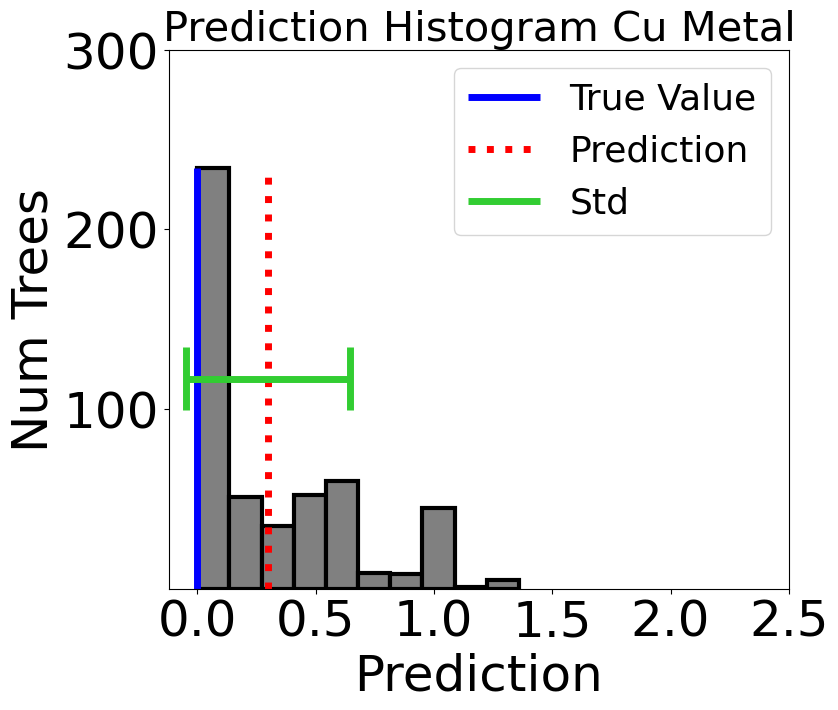

In [32]:
test_rf_obj.predict_experiment_random_forest('C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/Cu Metal Deconvolved Spectrum.dm4',
                                             1644, 'Cu Metal', exp_spectrum_type='TEAM I',
                                            smoothing_parms=[51,3], points_to_average=10, cumulative_spectrum=True,
                                            spectrum_energy_shift=0.0, theory_column='TEAM_1_aligned_925_970', 
                                            energies_range=[925,970], show_hist=True, show_plots=True, show_inputted_spectrum = True,
                                            savefigure=False)

<font size="6"> Experimental EELS vs Literature XAS Cu Metal and Cu2O. Figure S8

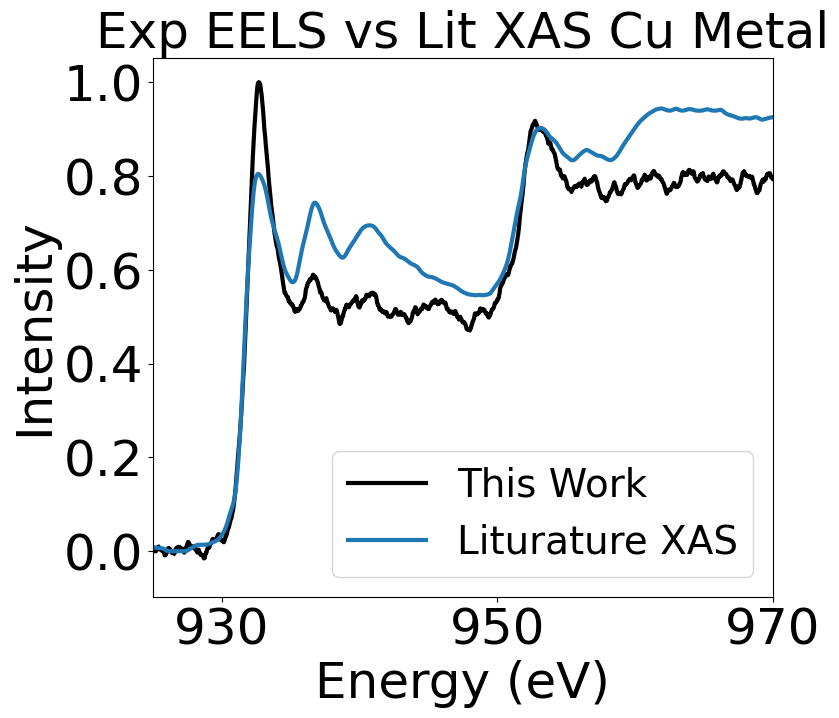

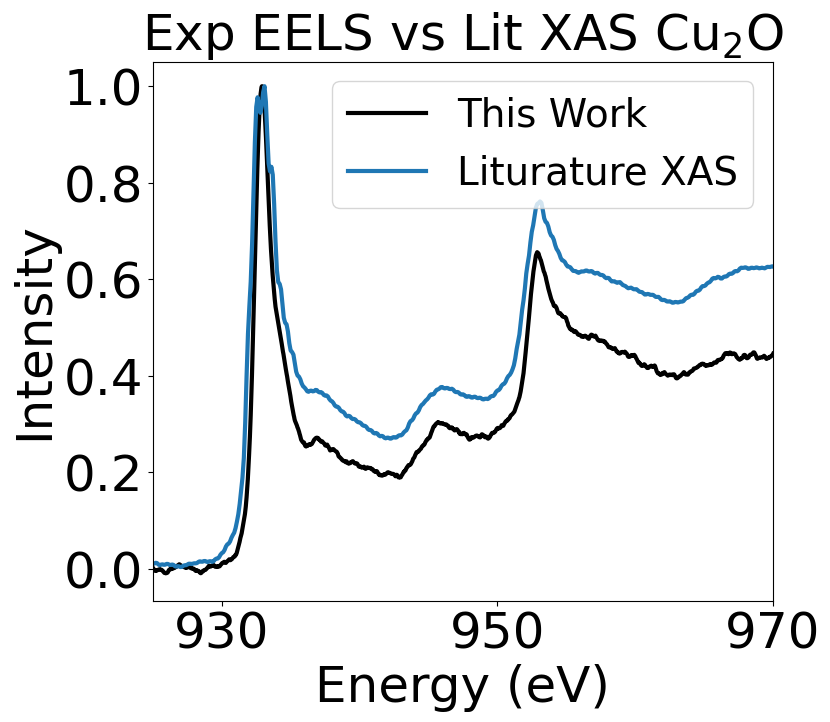

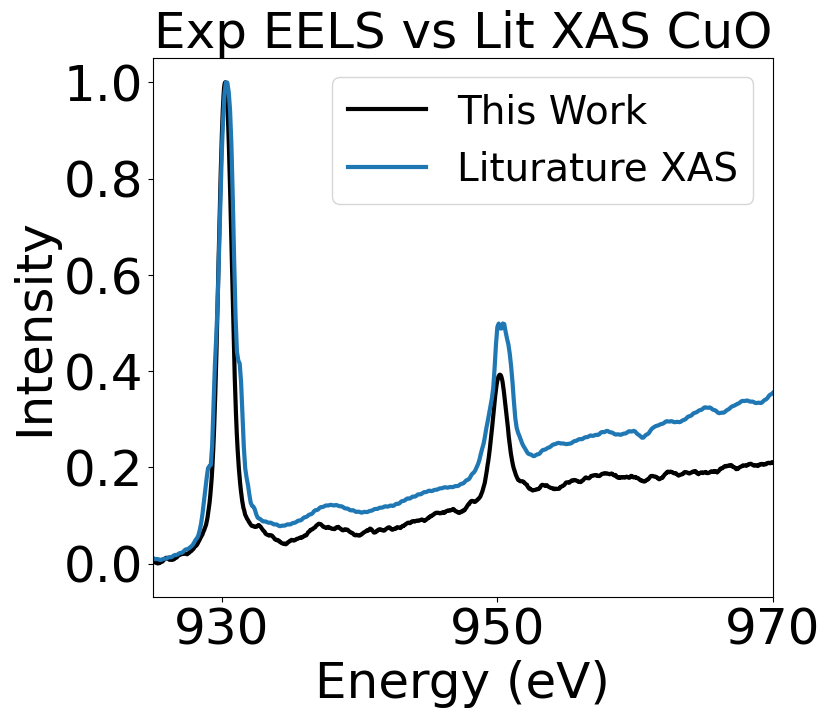

In [34]:
test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'Cu metal',
                           compare_to_lit = True, lit_spectrum = Cu_metal_path, lit_shift = -1.0, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS Cu Metal', show_experiment = True, savefigure=False)


test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'Cu2O',
                           compare_to_lit = True, lit_spectrum = Cu2O_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS Cu$_2$O', show_experiment = True, savefigure=False)

test_rf_obj.compare_simulation_to_experiment(show_feff = False, feff_shift = 0, material = 'CuO',
                           compare_to_lit = True, lit_spectrum = CuO_path, lit_shift = -1.2, xlims = [925,970],
                            title = 'Exp EELS vs Lit XAS CuO', show_experiment = True, savefigure=False)

<font size="6"> Simulated Mixture Spectra, Mixtures of Cu metal, Cu2O and CuO. Figure S9

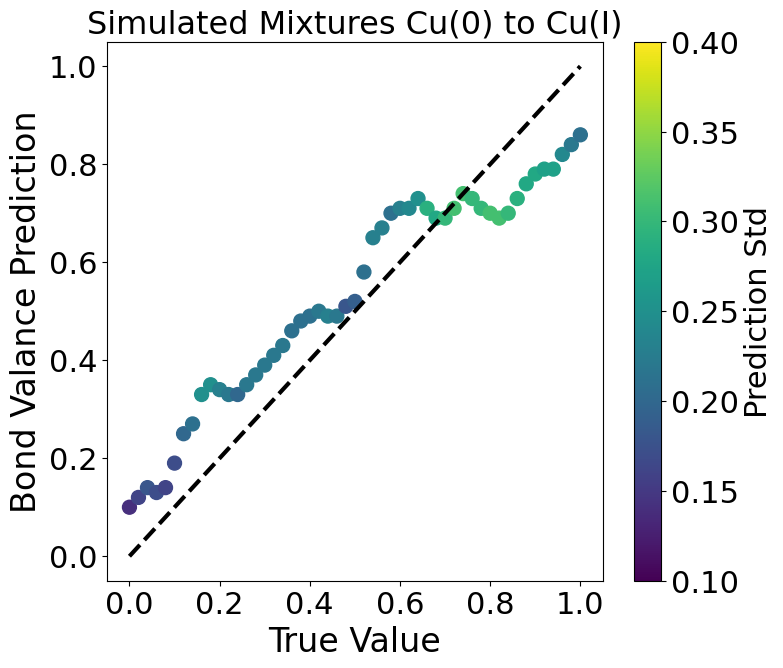

In [35]:
test_rf_obj.simulated_mixed_valent(catagory = '0-1', savefigure=False, colorbar_range = [0.1, 0.4])

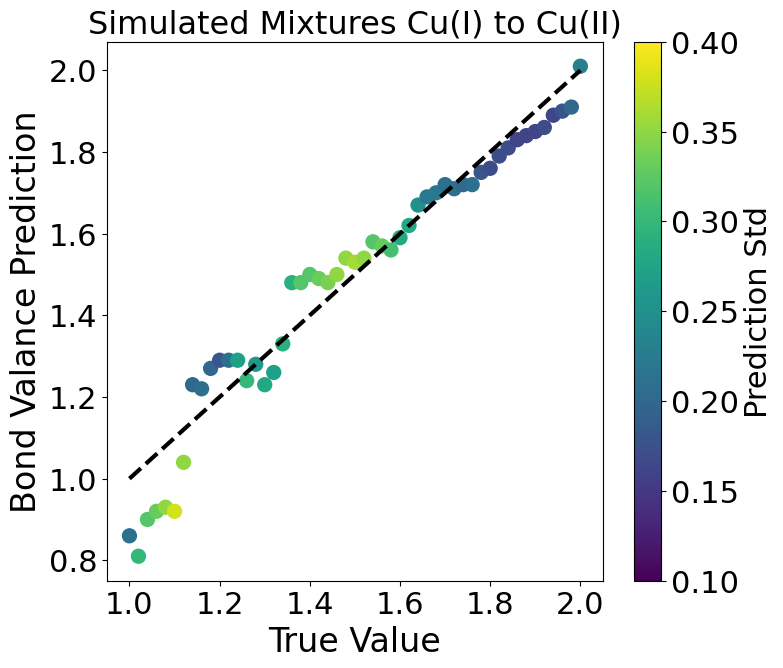

In [36]:
test_rf_obj.simulated_mixed_valent(catagory = '1-2', savefigure=False, colorbar_range = [0.1, 0.4])

<font size="6"> Impact of Smoothing on Experimental EELS Spectra Predictions. Figure S10

In [36]:
smoothings = [[5,3], [21,3], [35,3], [51,3], [75,3], [101,3], [125,3], [151,3]]

In [37]:
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', show_plots=False,
                                      shifts = [0.0], theory_column = 'TEAM_1_aligned_925_970', smoothings = smoothings, 
                                      show_hist=False, show_inputted_spectrum=False, savefigure=False, print_details=False,
                                     theory_indicies = [1644, 2246, 824])

╒═════════════════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Smoothing Window (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞═════════════════════════╪══════════════╪══════════════════╪════════════════════════╡
│                    0.15 │         0.38 │             0.41 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    0.63 │         0.31 │             0.36 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    1.05 │         0.29 │             0.35 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    1.53 │         0.3  │             0.35 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    2.25 │         0.3  │ 

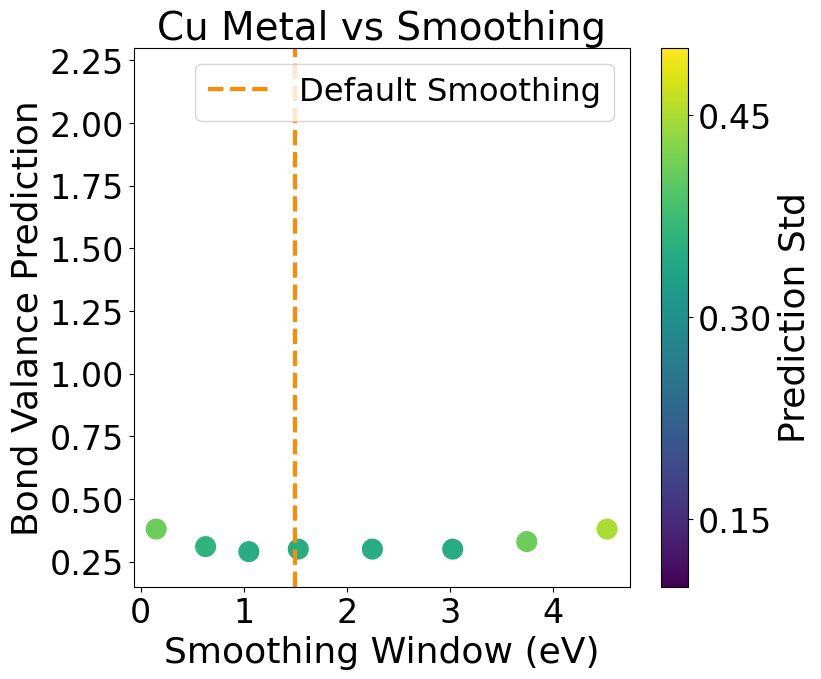

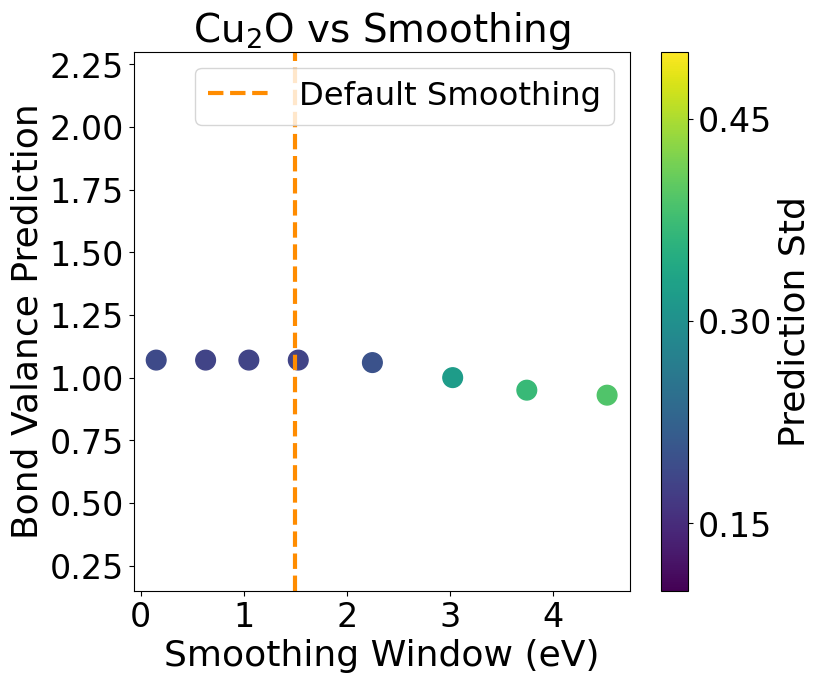

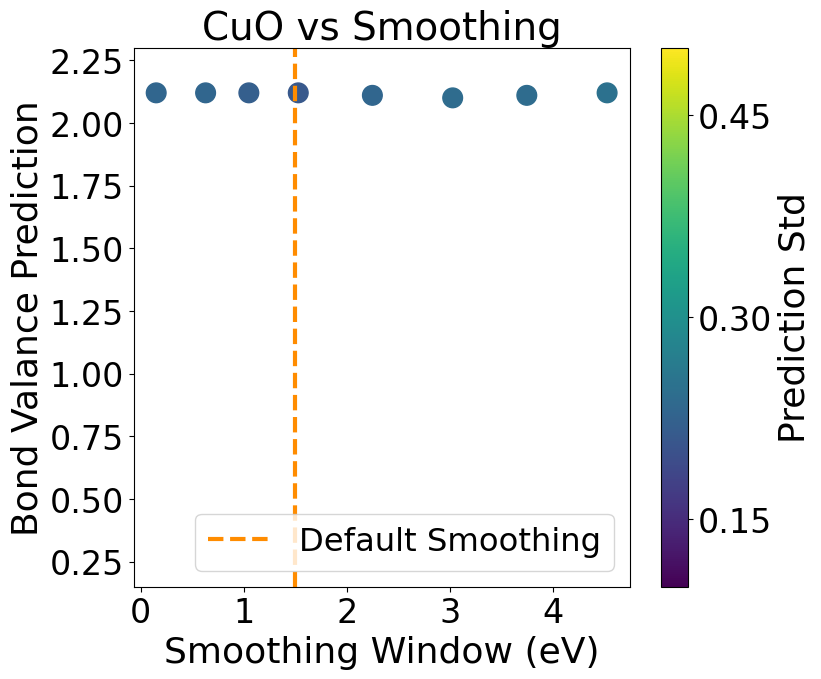

In [38]:
test_rf_obj.visualize_smoothings(show_table=True, savefigure=False)